# Lung Cancer Diagnosis ML + DL pipeline




✔ Preprocess - Contrast Enhancement and Data Augmentation

✔ Extract features using EfficientNet-B7

✔ Train a Model LightGBM for better accuracy

✔ Evaluate model performance with Recall, F1-score, precision analysis and Confusion Matrix

✔ Highlight Cancer-Affected Regions using Grad-CAM.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DataSet Used

In [ ]:
import os

dataset_path = "/content/drive/MyDrive/Dataset-Lungcancer/The IQ-OTHNCCD lung cancer dataset"

if os.path.exists(dataset_path):
    print("✅ Dataset path exists.")
else:
    print("❌ Dataset path NOT found. Check the path.")


✅ Dataset path exists.


# Preprocessing

In [ ]:
import os
import numpy as np
import cv2
import glob
import concurrent.futures
from skimage.filters import threshold_otsu
from skimage.morphology import binary_closing, remove_small_objects, disk

# Define Paths
dataset_path = "/content/drive/MyDrive/Dataset-Lungcancer/The IQ-OTHNCCD lung cancer dataset"
save_path = "/content/drive/MyDrive/Processed_Lung_Cancer_Data"
os.makedirs(save_path, exist_ok=True)



In [ ]:
categories = ["Bengin cases", "Malignant cases", "Normal cases"]
img_size = 256

# Image Preprocessing Function
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None, None

    # Denoising
    denoised_img = cv2.fastNlMeansDenoising(img, h=10, templateWindowSize=7, searchWindowSize=21)

    # Segmentation
    thresh = threshold_otsu(denoised_img)
    binary_mask = denoised_img > thresh
    binary_mask = binary_closing(binary_mask, disk(2))
    binary_mask = remove_small_objects(binary_mask, min_size=500)
    segmented_img = denoised_img * binary_mask

    # Resizing
    resized_img = cv2.resize(segmented_img, (img_size, img_size))

    return resized_img, None  # Return image and label



In [ ]:
# Load Data in Parallel
data, labels = [], []

def process_category(category, class_num):
    images, lbls = [], []
    path = os.path.join(dataset_path, category)
    image_files = glob.glob(os.path.join(path, "*.png"))  # Adjust extension if needed

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = executor.map(preprocess_image, image_files)

    for img, lbl in results:
        if img is not None:
            images.append(img)
            lbls.append(class_num)

    return images, lbls

In [ ]:
# Run Parallel Processing
for idx, category in enumerate(categories):
    cat_data, cat_labels = process_category(category, idx)
    data.extend(cat_data)
    labels.extend(cat_labels)

# Convert to NumPy Arrays
data = np.array(data, dtype=np.float32).reshape(-1, img_size, img_size, 1) / 255.0
labels = np.array(labels, dtype=np.int32)

# Save Processed Data to Drive
np.save(os.path.join(save_path, "lung_cancer_data.npy"), data)
np.save(os.path.join(save_path, "lung_cancer_labels.npy"), labels)

print("Dataset Loaded and Saved Successfully!")

Dataset Loaded and Saved Successfully!


# **Preprocessing:** Contrast Enhancement and Data Augmentation

In [ ]:
import os
import numpy as np
import cv2
import glob
import concurrent.futures
from skimage.exposure import equalize_hist
from skimage.util import random_noise
from skimage.transform import rotate
from skimage import img_as_ubyte

def enhance_contrast(image):
    """Apply histogram equalization for contrast enhancement."""
    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

def augment_image(image):
    """Apply data augmentation: rotation, flipping, brightness adjustment."""
    augmented_images = []

    # Rotate images by 90, 180, 270 degrees
    for angle in [90, 180, 270]:
        augmented_images.append(rotate(image, angle, mode='wrap'))

    # Flip images horizontally and vertically
    augmented_images.append(np.fliplr(image))
    augmented_images.append(np.flipud(image))

    # Adjust brightness
    brightness_factor = 1.5  # Increase brightness
    bright_image = np.clip(image * brightness_factor, 0, 255).astype(np.uint8)
    augmented_images.append(bright_image)

    return [img_as_ubyte(img) for img in augmented_images]

def process_image(image):
    """Enhance contrast and apply augmentation."""
    enhanced_image = enhance_contrast(image)
    augmented_images = augment_image(enhanced_image)
    return [enhanced_image] + augmented_images

def main():
    save_path = "/content/drive/MyDrive/Processed_Lung_Cancer_Data"
    os.makedirs(save_path, exist_ok=True)

    # Load saved dataset
    data = np.load(os.path.join(save_path, "lung_cancer_data.npy"))
    labels = np.load(os.path.join(save_path, "lung_cancer_labels.npy"))

    processed_data = []
    processed_labels = []

    # Get image shape from the first image
    img_shape = data.shape[1:3]

    for img, label in zip(data, labels):
        img = (img * 255).astype(np.uint8)  # Convert back to 8-bit image
        processed_images = process_image(img)
        processed_data.extend(processed_images)
        processed_labels.extend([label] * len(processed_images))

    # Convert to NumPy arrays and save
    processed_data = np.array(processed_data, dtype=np.float32).reshape(-1, img_shape[0], img_shape[1], 1) / 255.0
    processed_labels = np.array(processed_labels, dtype=np.int32)

    np.save(os.path.join(save_path, "enhanced_lung_cancer_data.npy"), processed_data)
    np.save(os.path.join(save_path, "enhanced_lung_cancer_labels.npy"), processed_labels)

    print("Contrast Enhancement and Data Augmentation Completed Successfully!")

if __name__ == "__main__":
    main()


Contrast Enhancement and Data Augmentation Completed Successfully!


# Count the files in each category

In [ ]:
import os
import glob

# Define dataset path
dataset_path = "/content/drive/MyDrive/Dataset-Lungcancer/The IQ-OTHNCCD lung cancer dataset"

# Function to check files in a category
def check_images(category):
    category_path = os.path.join(dataset_path, category)
    image_files = glob.glob(os.path.join(category_path, "*.*"))  # Match any file type
    print(f"Found {len(image_files)} files in {category}")
    print("Sample files:", image_files[:5])  # Print first 5 file names
    return image_files

# Check all categories
benign_images = check_images("Bengin cases")
malignant_images = check_images("Malignant cases")
normal_images = check_images("Normal cases")



Found 120 files in Bengin cases
Sample files: ['/content/drive/MyDrive/Dataset-Lungcancer/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (103).jpg', '/content/drive/MyDrive/Dataset-Lungcancer/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (105).jpg', '/content/drive/MyDrive/Dataset-Lungcancer/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (107).jpg', '/content/drive/MyDrive/Dataset-Lungcancer/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (108).jpg', '/content/drive/MyDrive/Dataset-Lungcancer/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (111).jpg']
Found 561 files in Malignant cases
Sample files: ['/content/drive/MyDrive/Dataset-Lungcancer/The IQ-OTHNCCD lung cancer dataset/Malignant cases/Malignant case (109).jpg', '/content/drive/MyDrive/Dataset-Lungcancer/The IQ-OTHNCCD lung cancer dataset/Malignant cases/Malignant case (120).jpg', '/content/drive/MyDrive/Dataset-Lungcancer/The IQ-OTHNCCD lung cancer dataset/Malignan

In [ ]:
import glob

image_files = []
for ext in ["*.png", "*.jpg", "*.jpeg", "*.bmp"]:
    image_files.extend(glob.glob(os.path.join(dataset_path, "**", ext), recursive=True))

print(f"🖼️ Found {len(image_files)} images.")


🖼️ Found 1097 images.


# Feature Extraction using **EfficientNet-B7**

Processing 120 images from Bengin cases...


  0%|          | 0/120 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


  1%|          | 1/120 [00:20<40:42, 20.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


  2%|▏         | 2/120 [00:20<17:00,  8.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  2%|▎         | 3/120 [00:21<09:20,  4.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


  3%|▎         | 4/120 [00:21<05:45,  2.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  4%|▍         | 5/120 [00:21<03:45,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


  5%|▌         | 6/120 [00:21<02:33,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


  6%|▌         | 7/120 [00:21<01:49,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


  7%|▋         | 8/120 [00:21<01:19,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


  8%|▊         | 9/120 [00:22<01:00,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


  8%|▊         | 10/120 [00:22<00:48,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


  9%|▉         | 11/120 [00:22<00:37,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 10%|█         | 12/120 [00:22<00:30,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 11%|█         | 13/120 [00:22<00:27,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 12%|█▏        | 14/120 [00:22<00:25,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 12%|█▎        | 15/120 [00:23<00:23,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 13%|█▎        | 16/120 [00:23<00:22,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 14%|█▍        | 17/120 [00:23<00:21,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 15%|█▌        | 18/120 [00:23<00:19,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 16%|█▌        | 19/120 [00:23<00:19,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 17%|█▋        | 20/120 [00:24<00:17,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 18%|█▊        | 21/120 [00:24<00:18,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 18%|█▊        | 22/120 [00:24<00:16,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 19%|█▉        | 23/120 [00:24<00:17,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 20%|██        | 24/120 [00:24<00:17,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 21%|██        | 25/120 [00:24<00:15,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 22%|██▏       | 26/120 [00:25<00:14,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 22%|██▎       | 27/120 [00:25<00:16,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 23%|██▎       | 28/120 [00:25<00:16,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 24%|██▍       | 29/120 [00:25<00:16,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 25%|██▌       | 30/120 [00:25<00:17,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 26%|██▌       | 31/120 [00:25<00:15,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 27%|██▋       | 32/120 [00:26<00:14,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 28%|██▊       | 33/120 [00:26<00:15,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 28%|██▊       | 34/120 [00:26<00:13,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 29%|██▉       | 35/120 [00:26<00:12,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 30%|███       | 36/120 [00:26<00:12,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 31%|███       | 37/120 [00:26<00:13,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 32%|███▏      | 38/120 [00:27<00:14,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 32%|███▎      | 39/120 [00:27<00:15,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 33%|███▎      | 40/120 [00:27<00:15,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 34%|███▍      | 41/120 [00:27<00:15,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 35%|███▌      | 42/120 [00:27<00:14,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 36%|███▌      | 43/120 [00:28<00:14,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 37%|███▋      | 44/120 [00:28<00:13,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 38%|███▊      | 45/120 [00:28<00:14,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 38%|███▊      | 46/120 [00:28<00:13,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 39%|███▉      | 47/120 [00:28<00:14,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 40%|████      | 48/120 [00:29<00:13,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 41%|████      | 49/120 [00:29<00:13,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 42%|████▏     | 50/120 [00:29<00:14,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 42%|████▎     | 51/120 [00:29<00:14,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 43%|████▎     | 52/120 [00:29<00:13,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 44%|████▍     | 53/120 [00:30<00:12,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 45%|████▌     | 54/120 [00:30<00:12,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 46%|████▌     | 55/120 [00:30<00:12,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 47%|████▋     | 56/120 [00:30<00:12,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 48%|████▊     | 57/120 [00:30<00:12,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 48%|████▊     | 58/120 [00:31<00:11,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 49%|████▉     | 59/120 [00:31<00:10,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 50%|█████     | 60/120 [00:31<00:09,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 51%|█████     | 61/120 [00:31<00:09,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 52%|█████▏    | 62/120 [00:31<00:08,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 52%|█████▎    | 63/120 [00:31<00:09,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 53%|█████▎    | 64/120 [00:31<00:09,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 54%|█████▍    | 65/120 [00:32<00:08,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 55%|█████▌    | 66/120 [00:32<00:08,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 56%|█████▌    | 67/120 [00:32<00:07,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 57%|█████▋    | 68/120 [00:32<00:07,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 57%|█████▊    | 69/120 [00:32<00:07,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 58%|█████▊    | 70/120 [00:32<00:07,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 59%|█████▉    | 71/120 [00:33<00:08,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 60%|██████    | 72/120 [00:33<00:07,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 61%|██████    | 73/120 [00:33<00:07,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 62%|██████▏   | 74/120 [00:33<00:07,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 62%|██████▎   | 75/120 [00:33<00:07,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 63%|██████▎   | 76/120 [00:33<00:07,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 64%|██████▍   | 77/120 [00:33<00:06,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 65%|██████▌   | 78/120 [00:34<00:07,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 66%|██████▌   | 79/120 [00:34<00:07,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 67%|██████▋   | 80/120 [00:34<00:06,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 68%|██████▊   | 81/120 [00:34<00:06,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 68%|██████▊   | 82/120 [00:34<00:06,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 69%|██████▉   | 83/120 [00:35<00:06,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 70%|███████   | 84/120 [00:35<00:05,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 71%|███████   | 85/120 [00:35<00:06,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 72%|███████▏  | 86/120 [00:35<00:05,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 72%|███████▎  | 87/120 [00:35<00:05,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 73%|███████▎  | 88/120 [00:35<00:05,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 74%|███████▍  | 89/120 [00:36<00:05,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 75%|███████▌  | 90/120 [00:36<00:04,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 76%|███████▌  | 91/120 [00:36<00:04,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 77%|███████▋  | 92/120 [00:36<00:04,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 78%|███████▊  | 93/120 [00:36<00:04,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 78%|███████▊  | 94/120 [00:36<00:03,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 79%|███████▉  | 95/120 [00:36<00:03,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 80%|████████  | 96/120 [00:37<00:03,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 81%|████████  | 97/120 [00:37<00:03,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 82%|████████▏ | 98/120 [00:37<00:03,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 82%|████████▎ | 99/120 [00:37<00:03,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 83%|████████▎ | 100/120 [00:37<00:03,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 84%|████████▍ | 101/120 [00:37<00:03,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 85%|████████▌ | 102/120 [00:38<00:03,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 86%|████████▌ | 103/120 [00:38<00:03,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 87%|████████▋ | 104/120 [00:38<00:02,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 88%|████████▊ | 105/120 [00:38<00:02,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 88%|████████▊ | 106/120 [00:38<00:02,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 89%|████████▉ | 107/120 [00:38<00:02,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 90%|█████████ | 108/120 [00:39<00:02,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 91%|█████████ | 109/120 [00:39<00:01,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 92%|█████████▏| 110/120 [00:39<00:01,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 92%|█████████▎| 111/120 [00:39<00:01,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 93%|█████████▎| 112/120 [00:39<00:01,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 94%|█████████▍| 113/120 [00:40<00:01,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 95%|█████████▌| 114/120 [00:40<00:01,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 96%|█████████▌| 115/120 [00:40<00:01,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 97%|█████████▋| 116/120 [00:40<00:00,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 98%|█████████▊| 117/120 [00:41<00:00,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 98%|█████████▊| 118/120 [00:41<00:00,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 99%|█████████▉| 119/120 [00:41<00:00,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


100%|██████████| 120/120 [00:41<00:00,  2.88it/s]


Processing 561 images from Malignant cases...


  0%|          | 0/561 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  0%|          | 1/561 [00:00<02:07,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  0%|          | 2/561 [00:00<01:58,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  1%|          | 3/561 [00:00<02:02,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  1%|          | 4/561 [00:00<02:00,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


  1%|          | 5/561 [00:01<01:57,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  1%|          | 6/561 [00:01<02:04,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  1%|          | 7/561 [00:02<05:51,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


  1%|▏         | 8/561 [00:02<04:33,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


  2%|▏         | 9/561 [00:03<03:42,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


  2%|▏         | 10/561 [00:03<03:08,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


  2%|▏         | 11/561 [00:03<02:43,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


  2%|▏         | 12/561 [00:03<02:19,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


  2%|▏         | 13/561 [00:03<02:09,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  2%|▏         | 14/561 [00:04<01:59,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


  3%|▎         | 15/561 [00:04<01:49,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


  3%|▎         | 16/561 [00:04<01:42,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  3%|▎         | 17/561 [00:04<01:36,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


  3%|▎         | 18/561 [00:04<01:39,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


  3%|▎         | 19/561 [00:04<01:41,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


  4%|▎         | 20/561 [00:05<01:35,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


  4%|▎         | 21/561 [00:05<01:39,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


  4%|▍         | 22/561 [00:05<01:31,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


  4%|▍         | 23/561 [00:05<01:35,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


  4%|▍         | 24/561 [00:05<01:29,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


  4%|▍         | 25/561 [00:06<01:33,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


  5%|▍         | 26/561 [00:06<01:38,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


  5%|▍         | 27/561 [00:06<01:40,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


  5%|▍         | 28/561 [00:06<01:41,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


  5%|▌         | 29/561 [00:06<01:33,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


  5%|▌         | 30/561 [00:06<01:37,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


  6%|▌         | 31/561 [00:07<01:32,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


  6%|▌         | 32/561 [00:07<01:26,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


  6%|▌         | 33/561 [00:07<01:31,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


  6%|▌         | 34/561 [00:07<01:35,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  6%|▌         | 35/561 [00:07<01:27,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


  6%|▋         | 36/561 [00:07<01:32,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


  7%|▋         | 37/561 [00:08<01:35,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  7%|▋         | 38/561 [00:08<01:38,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


  7%|▋         | 39/561 [00:08<01:31,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


  7%|▋         | 40/561 [00:08<01:35,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


  7%|▋         | 41/561 [00:08<01:28,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


  7%|▋         | 42/561 [00:08<01:22,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


  8%|▊         | 43/561 [00:09<01:29,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


  8%|▊         | 44/561 [00:09<01:22,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  8%|▊         | 45/561 [00:09<01:18,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


  8%|▊         | 46/561 [00:09<01:14,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


  8%|▊         | 47/561 [00:09<01:12,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


  9%|▊         | 48/561 [00:09<01:10,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


  9%|▊         | 49/561 [00:10<01:20,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


  9%|▉         | 50/561 [00:10<01:17,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  9%|▉         | 51/561 [00:10<01:13,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


  9%|▉         | 52/561 [00:10<01:21,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


  9%|▉         | 53/561 [00:10<01:27,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 10%|▉         | 54/561 [00:10<01:31,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 10%|▉         | 55/561 [00:11<01:38,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 10%|▉         | 56/561 [00:11<01:44,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 10%|█         | 57/561 [00:11<01:38,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 10%|█         | 58/561 [00:11<01:35,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 11%|█         | 59/561 [00:11<01:39,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 11%|█         | 60/561 [00:12<01:36,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 11%|█         | 61/561 [00:12<01:34,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 11%|█         | 62/561 [00:12<01:32,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 11%|█         | 63/561 [00:12<01:37,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 11%|█▏        | 64/561 [00:12<01:33,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 12%|█▏        | 65/561 [00:13<01:33,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 12%|█▏        | 66/561 [00:13<01:38,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 12%|█▏        | 67/561 [00:13<01:43,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 12%|█▏        | 68/561 [00:13<01:44,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 12%|█▏        | 69/561 [00:13<01:44,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 12%|█▏        | 70/561 [00:14<01:33,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 13%|█▎        | 71/561 [00:14<01:25,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 13%|█▎        | 72/561 [00:14<01:28,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 13%|█▎        | 73/561 [00:14<01:21,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 13%|█▎        | 74/561 [00:14<01:17,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 13%|█▎        | 75/561 [00:14<01:13,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 14%|█▎        | 76/561 [00:14<01:10,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 14%|█▎        | 77/561 [00:15<01:18,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 14%|█▍        | 78/561 [00:15<01:13,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 14%|█▍        | 79/561 [00:15<01:09,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 14%|█▍        | 80/561 [00:15<01:07,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 14%|█▍        | 81/561 [00:15<01:05,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 15%|█▍        | 82/561 [00:15<01:14,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 15%|█▍        | 83/561 [00:15<01:09,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 15%|█▍        | 84/561 [00:16<01:07,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 15%|█▌        | 85/561 [00:16<01:05,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 15%|█▌        | 86/561 [00:16<01:14,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 16%|█▌        | 87/561 [00:16<01:20,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 16%|█▌        | 88/561 [00:16<01:15,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 16%|█▌        | 89/561 [00:16<01:20,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 16%|█▌        | 90/561 [00:17<01:26,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 16%|█▌        | 91/561 [00:17<01:28,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 16%|█▋        | 92/561 [00:17<01:21,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 17%|█▋        | 93/561 [00:17<01:16,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 17%|█▋        | 94/561 [00:17<01:20,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 17%|█▋        | 95/561 [00:18<01:15,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 17%|█▋        | 96/561 [00:18<01:11,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 17%|█▋        | 97/561 [00:18<01:08,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 17%|█▋        | 98/561 [00:18<01:06,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 18%|█▊        | 99/561 [00:18<01:15,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 18%|█▊        | 100/561 [00:18<01:12,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 18%|█▊        | 101/561 [00:18<01:17,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 18%|█▊        | 102/561 [00:19<01:13,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 18%|█▊        | 103/561 [00:19<01:18,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 19%|█▊        | 104/561 [00:19<01:13,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 19%|█▊        | 105/561 [00:19<01:18,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 19%|█▉        | 106/561 [00:19<01:21,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 19%|█▉        | 107/561 [00:20<01:24,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 19%|█▉        | 108/561 [00:20<01:25,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 19%|█▉        | 109/561 [00:20<01:26,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 20%|█▉        | 110/561 [00:20<01:28,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 20%|█▉        | 111/561 [00:20<01:20,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 20%|█▉        | 112/561 [00:20<01:23,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 20%|██        | 113/561 [00:21<01:17,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 20%|██        | 114/561 [00:21<01:12,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 20%|██        | 115/561 [00:21<01:17,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 21%|██        | 116/561 [00:21<01:12,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 21%|██        | 117/561 [00:21<01:08,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 21%|██        | 118/561 [00:21<01:14,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 21%|██        | 119/561 [00:22<01:17,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 21%|██▏       | 120/561 [00:22<01:11,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 22%|██▏       | 121/561 [00:22<01:15,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 22%|██▏       | 122/561 [00:22<01:11,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 22%|██▏       | 123/561 [00:22<01:15,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 22%|██▏       | 124/561 [00:22<01:10,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 22%|██▏       | 125/561 [00:23<01:07,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 22%|██▏       | 126/561 [00:23<01:04,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 23%|██▎       | 127/561 [00:23<01:10,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 23%|██▎       | 128/561 [00:23<01:15,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 23%|██▎       | 129/561 [00:23<01:18,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 23%|██▎       | 130/561 [00:24<01:25,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 23%|██▎       | 131/561 [00:24<01:29,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 24%|██▎       | 132/561 [00:24<01:25,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 24%|██▎       | 133/561 [00:24<01:27,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 24%|██▍       | 134/561 [00:24<01:24,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 24%|██▍       | 135/561 [00:25<01:27,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 24%|██▍       | 136/561 [00:25<01:29,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 24%|██▍       | 137/561 [00:25<01:25,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 25%|██▍       | 138/561 [00:25<01:24,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 25%|██▍       | 139/561 [00:25<01:26,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 25%|██▍       | 140/561 [00:26<01:29,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|██▌       | 141/561 [00:26<01:30,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 25%|██▌       | 142/561 [00:26<01:30,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 25%|██▌       | 143/561 [00:26<01:26,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 26%|██▌       | 144/561 [00:26<01:19,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 26%|██▌       | 145/561 [00:27<01:14,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 26%|██▌       | 146/561 [00:27<01:12,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 26%|██▌       | 147/561 [00:27<01:15,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 26%|██▋       | 148/561 [00:27<01:10,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 27%|██▋       | 149/561 [00:27<01:07,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 27%|██▋       | 150/561 [00:27<01:06,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 27%|██▋       | 151/561 [00:28<01:11,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 27%|██▋       | 152/561 [00:28<01:06,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 27%|██▋       | 153/561 [00:28<01:04,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 27%|██▋       | 154/561 [00:28<01:09,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 28%|██▊       | 155/561 [00:28<01:12,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 28%|██▊       | 156/561 [00:28<01:16,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 28%|██▊       | 157/561 [00:29<01:17,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 28%|██▊       | 158/561 [00:29<01:10,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 28%|██▊       | 159/561 [00:29<01:06,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 29%|██▊       | 160/561 [00:29<01:02,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 29%|██▊       | 161/561 [00:29<01:08,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 29%|██▉       | 162/561 [00:29<01:12,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 29%|██▉       | 163/561 [00:30<01:06,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 29%|██▉       | 164/561 [00:30<01:10,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 29%|██▉       | 165/561 [00:30<01:12,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 30%|██▉       | 166/561 [00:30<01:14,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 30%|██▉       | 167/561 [00:30<01:09,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 30%|██▉       | 168/561 [00:30<01:05,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 30%|███       | 169/561 [00:31<01:09,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 30%|███       | 170/561 [00:31<01:13,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 30%|███       | 171/561 [00:31<01:07,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 31%|███       | 172/561 [00:31<01:10,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 31%|███       | 173/561 [00:31<01:05,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 31%|███       | 174/561 [00:32<01:08,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 31%|███       | 175/561 [00:32<01:03,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 31%|███▏      | 176/561 [00:32<01:00,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 32%|███▏      | 177/561 [00:32<01:05,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 32%|███▏      | 178/561 [00:32<01:00,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 32%|███▏      | 179/561 [00:32<01:05,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 32%|███▏      | 180/561 [00:33<01:01,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 32%|███▏      | 181/561 [00:33<01:05,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 32%|███▏      | 182/561 [00:33<01:01,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 33%|███▎      | 183/561 [00:33<01:05,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 33%|███▎      | 184/561 [00:33<01:08,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 33%|███▎      | 185/561 [00:33<01:03,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 33%|███▎      | 186/561 [00:34<00:59,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 33%|███▎      | 187/561 [00:34<00:56,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 34%|███▎      | 188/561 [00:34<00:53,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 34%|███▎      | 189/561 [00:34<00:52,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 34%|███▍      | 190/561 [00:34<00:52,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 34%|███▍      | 191/561 [00:34<00:58,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 34%|███▍      | 192/561 [00:34<00:56,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 34%|███▍      | 193/561 [00:35<01:01,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 35%|███▍      | 194/561 [00:35<00:57,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 35%|███▍      | 195/561 [00:35<01:02,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 35%|███▍      | 196/561 [00:35<00:58,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 35%|███▌      | 197/561 [00:35<01:02,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 35%|███▌      | 198/561 [00:35<00:58,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 35%|███▌      | 199/561 [00:36<01:04,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 36%|███▌      | 200/561 [00:36<00:58,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 36%|███▌      | 201/561 [00:36<01:02,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 36%|███▌      | 202/561 [00:36<01:04,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 36%|███▌      | 203/561 [00:36<01:11,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 36%|███▋      | 204/561 [00:37<01:15,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 37%|███▋      | 205/561 [00:37<01:15,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 37%|███▋      | 206/561 [00:37<01:13,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 37%|███▋      | 207/561 [00:37<01:10,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 37%|███▋      | 208/561 [00:37<01:13,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 37%|███▋      | 209/561 [00:38<01:16,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 37%|███▋      | 210/561 [00:38<01:12,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 38%|███▊      | 211/561 [00:38<01:14,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 38%|███▊      | 212/561 [00:38<01:13,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 38%|███▊      | 213/561 [00:38<01:11,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 38%|███▊      | 214/561 [00:39<01:15,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 38%|███▊      | 215/561 [00:39<01:12,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 39%|███▊      | 216/561 [00:39<01:10,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 39%|███▊      | 217/561 [00:39<01:11,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 39%|███▉      | 218/561 [00:40<01:10,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 39%|███▉      | 219/561 [00:40<01:10,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 39%|███▉      | 220/561 [00:40<01:09,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 39%|███▉      | 221/561 [00:40<01:09,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 40%|███▉      | 222/561 [00:40<01:09,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 40%|███▉      | 223/561 [00:41<01:08,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 40%|███▉      | 224/561 [00:41<01:08,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 40%|████      | 225/561 [00:41<01:02,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 40%|████      | 226/561 [00:41<00:58,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 40%|████      | 227/561 [00:41<00:55,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 41%|████      | 228/561 [00:41<00:58,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 41%|████      | 229/561 [00:42<01:00,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 41%|████      | 230/561 [00:42<01:03,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 41%|████      | 231/561 [00:42<01:03,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 41%|████▏     | 232/561 [00:42<01:00,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 42%|████▏     | 233/561 [00:42<01:01,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 42%|████▏     | 234/561 [00:43<01:02,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 42%|████▏     | 235/561 [00:43<00:57,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 42%|████▏     | 236/561 [00:43<00:59,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 42%|████▏     | 237/561 [00:43<00:55,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 42%|████▏     | 238/561 [00:43<00:53,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 43%|████▎     | 239/561 [00:43<00:56,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 43%|████▎     | 240/561 [00:44<00:58,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 43%|████▎     | 241/561 [00:44<00:53,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 43%|████▎     | 242/561 [00:44<00:56,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 43%|████▎     | 243/561 [00:44<00:53,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 43%|████▎     | 244/561 [00:44<00:51,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 44%|████▎     | 245/561 [00:44<00:55,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 44%|████▍     | 246/561 [00:45<00:52,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 44%|████▍     | 247/561 [00:45<00:51,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 44%|████▍     | 248/561 [00:45<00:54,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 44%|████▍     | 249/561 [00:45<00:50,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 45%|████▍     | 250/561 [00:45<00:53,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 45%|████▍     | 251/561 [00:45<00:51,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 45%|████▍     | 252/561 [00:46<00:54,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 45%|████▌     | 253/561 [00:46<00:56,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 45%|████▌     | 254/561 [00:46<00:52,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 45%|████▌     | 255/561 [00:46<00:54,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 46%|████▌     | 256/561 [00:46<00:56,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 46%|████▌     | 257/561 [00:47<00:57,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 46%|████▌     | 258/561 [00:47<00:58,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 46%|████▌     | 259/561 [00:47<00:59,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 46%|████▋     | 260/561 [00:47<00:59,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 47%|████▋     | 261/561 [00:47<00:59,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 47%|████▋     | 262/561 [00:48<00:59,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 47%|████▋     | 263/561 [00:48<00:53,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 47%|████▋     | 264/561 [00:48<00:50,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 47%|████▋     | 265/561 [00:48<00:52,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 47%|████▋     | 266/561 [00:48<00:54,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 48%|████▊     | 267/561 [00:48<00:51,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 48%|████▊     | 268/561 [00:49<00:53,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 48%|████▊     | 269/561 [00:49<00:55,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 48%|████▊     | 270/561 [00:49<00:51,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 48%|████▊     | 271/561 [00:49<00:48,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 48%|████▊     | 272/561 [00:49<00:50,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 49%|████▊     | 273/561 [00:49<00:50,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 49%|████▉     | 274/561 [00:50<00:54,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 49%|████▉     | 275/561 [00:50<00:57,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 49%|████▉     | 276/561 [00:50<00:54,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 49%|████▉     | 277/561 [00:50<00:53,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 50%|████▉     | 278/561 [00:50<00:53,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 50%|████▉     | 279/561 [00:51<00:56,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 50%|████▉     | 280/561 [00:51<00:58,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 50%|█████     | 281/561 [00:51<00:59,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 50%|█████     | 282/561 [00:51<00:57,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 50%|█████     | 283/561 [00:52<00:59,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 51%|█████     | 284/561 [00:52<00:57,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 51%|█████     | 285/561 [00:52<01:00,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 51%|█████     | 286/561 [00:52<00:58,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 51%|█████     | 287/561 [00:52<00:54,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 51%|█████▏    | 288/561 [00:52<00:50,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 52%|█████▏    | 289/561 [00:53<00:47,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 52%|█████▏    | 290/561 [00:53<00:49,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 52%|█████▏    | 291/561 [00:53<00:47,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 52%|█████▏    | 292/561 [00:53<00:46,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 52%|█████▏    | 293/561 [00:53<00:45,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 52%|█████▏    | 294/561 [00:54<00:47,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 53%|█████▎    | 295/561 [00:54<00:45,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 53%|█████▎    | 296/561 [00:54<00:47,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 53%|█████▎    | 297/561 [00:54<00:45,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 53%|█████▎    | 298/561 [00:54<00:42,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 53%|█████▎    | 299/561 [00:54<00:41,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 53%|█████▎    | 300/561 [00:54<00:39,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 54%|█████▎    | 301/561 [00:55<00:39,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 54%|█████▍    | 302/561 [00:55<00:39,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 54%|█████▍    | 303/561 [00:55<00:43,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 54%|█████▍    | 304/561 [00:55<00:41,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 54%|█████▍    | 305/561 [00:55<00:44,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 55%|█████▍    | 306/561 [00:55<00:41,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 55%|█████▍    | 307/561 [00:56<00:39,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 55%|█████▍    | 308/561 [00:56<00:42,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 55%|█████▌    | 309/561 [00:56<00:40,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 55%|█████▌    | 310/561 [00:56<00:39,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 55%|█████▌    | 311/561 [00:56<00:42,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 56%|█████▌    | 312/561 [00:56<00:44,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 56%|█████▌    | 313/561 [00:57<00:45,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 56%|█████▌    | 314/561 [00:57<00:47,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 56%|█████▌    | 315/561 [00:57<00:47,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 56%|█████▋    | 316/561 [00:57<00:43,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 57%|█████▋    | 317/561 [00:57<00:41,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 57%|█████▋    | 318/561 [00:58<00:38,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 57%|█████▋    | 319/561 [00:58<00:41,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 57%|█████▋    | 320/561 [00:58<00:38,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 57%|█████▋    | 321/561 [00:58<00:36,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 57%|█████▋    | 322/561 [00:58<00:36,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 58%|█████▊    | 323/561 [00:58<00:39,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 58%|█████▊    | 324/561 [00:58<00:37,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 58%|█████▊    | 325/561 [00:59<00:39,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 58%|█████▊    | 326/561 [00:59<00:41,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 58%|█████▊    | 327/561 [00:59<00:38,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 58%|█████▊    | 328/561 [00:59<00:40,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 59%|█████▊    | 329/561 [00:59<00:38,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 59%|█████▉    | 330/561 [01:00<00:36,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 59%|█████▉    | 331/561 [01:00<00:39,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 59%|█████▉    | 332/561 [01:00<00:38,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 59%|█████▉    | 333/561 [01:00<00:40,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 60%|█████▉    | 334/561 [01:00<00:42,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 60%|█████▉    | 335/561 [01:00<00:39,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 60%|█████▉    | 336/561 [01:01<00:40,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 60%|██████    | 337/561 [01:01<00:41,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 60%|██████    | 338/561 [01:01<00:38,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 60%|██████    | 339/561 [01:01<00:40,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 61%|██████    | 340/561 [01:01<00:41,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 61%|██████    | 341/561 [01:01<00:38,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 61%|██████    | 342/561 [01:02<00:40,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 61%|██████    | 343/561 [01:02<00:40,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 61%|██████▏   | 344/561 [01:02<00:41,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 61%|██████▏   | 345/561 [01:02<00:41,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 62%|██████▏   | 346/561 [01:03<00:43,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 62%|██████▏   | 347/561 [01:03<00:44,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 62%|██████▏   | 348/561 [01:03<00:42,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 62%|██████▏   | 349/561 [01:03<00:43,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 62%|██████▏   | 350/561 [01:03<00:42,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 63%|██████▎   | 351/561 [01:04<00:44,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 63%|██████▎   | 352/561 [01:04<00:43,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 63%|██████▎   | 353/561 [01:04<00:42,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 63%|██████▎   | 354/561 [01:04<00:42,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 63%|██████▎   | 355/561 [01:04<00:44,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 63%|██████▎   | 356/561 [01:05<00:42,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 64%|██████▎   | 357/561 [01:05<00:44,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 64%|██████▍   | 358/561 [01:05<00:44,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 64%|██████▍   | 359/561 [01:05<00:45,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 64%|██████▍   | 360/561 [01:05<00:41,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 64%|██████▍   | 361/561 [01:06<00:40,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 65%|██████▍   | 362/561 [01:06<00:38,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 65%|██████▍   | 363/561 [01:06<00:38,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 65%|██████▍   | 364/561 [01:06<00:39,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 65%|██████▌   | 365/561 [01:06<00:36,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 65%|██████▌   | 366/561 [01:07<00:35,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 65%|██████▌   | 367/561 [01:07<00:36,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 66%|██████▌   | 368/561 [01:07<00:36,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 66%|██████▌   | 369/561 [01:07<00:34,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 66%|██████▌   | 370/561 [01:07<00:32,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 66%|██████▌   | 371/561 [01:07<00:31,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 66%|██████▋   | 372/561 [01:08<00:30,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 66%|██████▋   | 373/561 [01:08<00:33,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 67%|██████▋   | 374/561 [01:08<00:34,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 67%|██████▋   | 375/561 [01:08<00:31,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 67%|██████▋   | 376/561 [01:08<00:30,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 67%|██████▋   | 377/561 [01:08<00:30,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 67%|██████▋   | 378/561 [01:09<00:33,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 68%|██████▊   | 379/561 [01:09<00:30,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 68%|██████▊   | 380/561 [01:09<00:29,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 68%|██████▊   | 381/561 [01:09<00:28,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 68%|██████▊   | 382/561 [01:09<00:30,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 68%|██████▊   | 383/561 [01:09<00:28,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 68%|██████▊   | 384/561 [01:10<00:27,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 69%|██████▊   | 385/561 [01:10<00:29,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 69%|██████▉   | 386/561 [01:10<00:31,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 69%|██████▉   | 387/561 [01:10<00:29,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 69%|██████▉   | 388/561 [01:10<00:30,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 69%|██████▉   | 389/561 [01:10<00:28,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 70%|██████▉   | 390/561 [01:11<00:30,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 70%|██████▉   | 391/561 [01:11<00:31,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 70%|██████▉   | 392/561 [01:11<00:32,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 70%|███████   | 393/561 [01:11<00:32,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 70%|███████   | 394/561 [01:11<00:29,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 70%|███████   | 395/561 [01:12<00:30,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 71%|███████   | 396/561 [01:12<00:27,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 71%|███████   | 397/561 [01:12<00:26,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 71%|███████   | 398/561 [01:12<00:28,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 71%|███████   | 399/561 [01:12<00:29,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 71%|███████▏  | 400/561 [01:12<00:30,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 71%|███████▏  | 401/561 [01:13<00:30,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 72%|███████▏  | 402/561 [01:13<00:31,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 72%|███████▏  | 403/561 [01:13<00:28,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 72%|███████▏  | 404/561 [01:13<00:29,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 72%|███████▏  | 405/561 [01:13<00:29,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 72%|███████▏  | 406/561 [01:14<00:26,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 73%|███████▎  | 407/561 [01:14<00:25,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 73%|███████▎  | 408/561 [01:14<00:24,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 73%|███████▎  | 409/561 [01:14<00:23,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 73%|███████▎  | 410/561 [01:14<00:22,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 73%|███████▎  | 411/561 [01:14<00:22,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 73%|███████▎  | 412/561 [01:14<00:24,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 74%|███████▎  | 413/561 [01:15<00:26,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 74%|███████▍  | 414/561 [01:15<00:27,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 74%|███████▍  | 415/561 [01:15<00:24,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 74%|███████▍  | 416/561 [01:15<00:26,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 74%|███████▍  | 417/561 [01:15<00:27,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 75%|███████▍  | 418/561 [01:16<00:29,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 75%|███████▍  | 419/561 [01:16<00:27,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 75%|███████▍  | 420/561 [01:16<00:26,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 75%|███████▌  | 421/561 [01:16<00:26,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 75%|███████▌  | 422/561 [01:16<00:27,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 75%|███████▌  | 423/561 [01:17<00:28,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 76%|███████▌  | 424/561 [01:17<00:28,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 76%|███████▌  | 425/561 [01:17<00:28,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 76%|███████▌  | 426/561 [01:17<00:27,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 76%|███████▌  | 427/561 [01:18<00:28,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 76%|███████▋  | 428/561 [01:18<00:28,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 76%|███████▋  | 429/561 [01:18<00:28,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 77%|███████▋  | 430/561 [01:18<00:28,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 77%|███████▋  | 431/561 [01:18<00:27,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 77%|███████▋  | 432/561 [01:19<00:26,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 77%|███████▋  | 433/561 [01:19<00:24,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 77%|███████▋  | 434/561 [01:19<00:22,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 78%|███████▊  | 435/561 [01:19<00:21,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 78%|███████▊  | 436/561 [01:19<00:20,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 78%|███████▊  | 437/561 [01:19<00:22,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 78%|███████▊  | 438/561 [01:20<00:22,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|███████▊  | 439/561 [01:20<00:23,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|███████▊  | 440/561 [01:20<00:25,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 79%|███████▊  | 441/561 [01:20<00:25,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 79%|███████▉  | 442/561 [01:20<00:24,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 79%|███████▉  | 443/561 [01:21<00:24,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 79%|███████▉  | 444/561 [01:21<00:24,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 79%|███████▉  | 445/561 [01:21<00:24,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 80%|███████▉  | 446/561 [01:21<00:25,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 80%|███████▉  | 447/561 [01:22<00:25,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 80%|███████▉  | 448/561 [01:22<00:24,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 80%|████████  | 449/561 [01:22<00:24,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 80%|████████  | 450/561 [01:22<00:24,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 80%|████████  | 451/561 [01:22<00:23,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 81%|████████  | 452/561 [01:23<00:23,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 81%|████████  | 453/561 [01:23<00:21,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 81%|████████  | 454/561 [01:23<00:21,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 81%|████████  | 455/561 [01:23<00:19,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 81%|████████▏ | 456/561 [01:23<00:18,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 81%|████████▏ | 457/561 [01:23<00:17,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 82%|████████▏ | 458/561 [01:24<00:18,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 82%|████████▏ | 459/561 [01:24<00:17,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 82%|████████▏ | 460/561 [01:24<00:18,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 82%|████████▏ | 461/561 [01:24<00:18,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 82%|████████▏ | 462/561 [01:24<00:19,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 83%|████████▎ | 463/561 [01:25<00:19,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 83%|████████▎ | 464/561 [01:25<00:19,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 83%|████████▎ | 465/561 [01:25<00:18,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 83%|████████▎ | 466/561 [01:25<00:17,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 83%|████████▎ | 467/561 [01:25<00:17,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 83%|████████▎ | 468/561 [01:26<00:17,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 84%|████████▎ | 469/561 [01:26<00:17,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 84%|████████▍ | 470/561 [01:26<00:16,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 84%|████████▍ | 471/561 [01:26<00:15,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 84%|████████▍ | 472/561 [01:26<00:16,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 84%|████████▍ | 473/561 [01:26<00:15,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 84%|████████▍ | 474/561 [01:27<00:15,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 85%|████████▍ | 475/561 [01:27<00:14,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 85%|████████▍ | 476/561 [01:27<00:14,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 85%|████████▌ | 477/561 [01:27<00:13,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 85%|████████▌ | 478/561 [01:27<00:12,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 85%|████████▌ | 479/561 [01:27<00:13,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 86%|████████▌ | 480/561 [01:28<00:12,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 86%|████████▌ | 481/561 [01:28<00:12,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 86%|████████▌ | 482/561 [01:28<00:11,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 86%|████████▌ | 483/561 [01:28<00:12,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 86%|████████▋ | 484/561 [01:28<00:12,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 86%|████████▋ | 485/561 [01:28<00:13,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 87%|████████▋ | 486/561 [01:29<00:14,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 87%|████████▋ | 487/561 [01:29<00:14,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 87%|████████▋ | 488/561 [01:29<00:13,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 87%|████████▋ | 489/561 [01:29<00:14,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 87%|████████▋ | 490/561 [01:29<00:13,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 88%|████████▊ | 491/561 [01:30<00:14,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 88%|████████▊ | 492/561 [01:30<00:14,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 88%|████████▊ | 493/561 [01:30<00:14,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 88%|████████▊ | 494/561 [01:30<00:14,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 88%|████████▊ | 495/561 [01:31<00:14,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|████████▊ | 496/561 [01:31<00:14,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 89%|████████▊ | 497/561 [01:31<00:14,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 89%|████████▉ | 498/561 [01:31<00:14,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 89%|████████▉ | 499/561 [01:31<00:13,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 89%|████████▉ | 500/561 [01:32<00:11,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 89%|████████▉ | 501/561 [01:32<00:11,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 89%|████████▉ | 502/561 [01:32<00:11,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 90%|████████▉ | 503/561 [01:32<00:10,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 90%|████████▉ | 504/561 [01:32<00:09,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 90%|█████████ | 505/561 [01:32<00:09,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 90%|█████████ | 506/561 [01:33<00:08,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 90%|█████████ | 507/561 [01:33<00:09,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 91%|█████████ | 508/561 [01:33<00:08,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 91%|█████████ | 509/561 [01:33<00:09,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 91%|█████████ | 510/561 [01:33<00:08,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 91%|█████████ | 511/561 [01:34<00:08,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 91%|█████████▏| 512/561 [01:34<00:08,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 91%|█████████▏| 513/561 [01:34<00:07,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 92%|█████████▏| 514/561 [01:34<00:08,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 92%|█████████▏| 515/561 [01:34<00:07,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 92%|█████████▏| 516/561 [01:34<00:07,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 92%|█████████▏| 517/561 [01:35<00:07,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 92%|█████████▏| 518/561 [01:35<00:07,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 93%|█████████▎| 519/561 [01:35<00:07,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 93%|█████████▎| 520/561 [01:35<00:07,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 93%|█████████▎| 521/561 [01:35<00:07,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 93%|█████████▎| 522/561 [01:35<00:07,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 93%|█████████▎| 523/561 [01:36<00:07,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 93%|█████████▎| 524/561 [01:36<00:06,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 94%|█████████▎| 525/561 [01:36<00:05,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 94%|█████████▍| 526/561 [01:36<00:06,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 94%|█████████▍| 527/561 [01:36<00:05,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 94%|█████████▍| 528/561 [01:37<00:06,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 94%|█████████▍| 529/561 [01:37<00:05,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 94%|█████████▍| 530/561 [01:37<00:05,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 95%|█████████▍| 531/561 [01:37<00:05,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 95%|█████████▍| 532/561 [01:37<00:05,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 95%|█████████▌| 533/561 [01:37<00:04,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 95%|█████████▌| 534/561 [01:38<00:04,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 95%|█████████▌| 535/561 [01:38<00:04,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 96%|█████████▌| 536/561 [01:38<00:04,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 96%|█████████▌| 537/561 [01:38<00:04,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 96%|█████████▌| 538/561 [01:38<00:03,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 96%|█████████▌| 539/561 [01:38<00:03,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 96%|█████████▋| 540/561 [01:39<00:03,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 96%|█████████▋| 541/561 [01:39<00:03,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 97%|█████████▋| 542/561 [01:39<00:03,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|█████████▋| 543/561 [01:39<00:03,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 97%|█████████▋| 544/561 [01:39<00:03,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 97%|█████████▋| 545/561 [01:40<00:03,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 97%|█████████▋| 546/561 [01:40<00:02,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 98%|█████████▊| 547/561 [01:40<00:02,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 98%|█████████▊| 548/561 [01:40<00:02,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 98%|█████████▊| 549/561 [01:40<00:02,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 98%|█████████▊| 550/561 [01:40<00:02,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 98%|█████████▊| 551/561 [01:41<00:01,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 98%|█████████▊| 552/561 [01:41<00:01,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 99%|█████████▊| 553/561 [01:41<00:01,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 99%|█████████▉| 554/561 [01:41<00:01,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 99%|█████████▉| 555/561 [01:41<00:01,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 99%|█████████▉| 556/561 [01:41<00:00,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 99%|█████████▉| 557/561 [01:42<00:00,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 99%|█████████▉| 558/561 [01:42<00:00,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


100%|█████████▉| 559/561 [01:42<00:00,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


100%|█████████▉| 560/561 [01:42<00:00,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


100%|██████████| 561/561 [01:43<00:00,  5.45it/s]


Processing 416 images from Normal cases...


  0%|          | 0/416 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  0%|          | 1/416 [00:00<01:40,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


  0%|          | 2/416 [00:00<01:21,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


  1%|          | 3/416 [00:00<01:17,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


  1%|          | 4/416 [00:00<01:22,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  1%|          | 5/416 [00:02<04:18,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


  1%|▏         | 6/416 [00:02<03:18,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


  2%|▏         | 7/416 [00:02<02:35,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


  2%|▏         | 8/416 [00:02<02:11,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


  2%|▏         | 9/416 [00:02<01:49,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


  2%|▏         | 10/416 [00:03<01:41,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


  3%|▎         | 11/416 [00:03<01:30,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


  3%|▎         | 12/416 [00:03<01:21,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


  3%|▎         | 13/416 [00:03<01:15,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


  3%|▎         | 14/416 [00:03<01:11,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


  4%|▎         | 15/416 [00:03<01:08,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


  4%|▍         | 16/416 [00:04<01:05,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  4%|▍         | 17/416 [00:04<01:06,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


  4%|▍         | 18/416 [00:04<01:12,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


  5%|▍         | 19/416 [00:04<01:15,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


  5%|▍         | 20/416 [00:04<01:17,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


  5%|▌         | 21/416 [00:05<01:18,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


  5%|▌         | 22/416 [00:05<01:18,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


  6%|▌         | 23/416 [00:05<01:18,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


  6%|▌         | 24/416 [00:05<01:12,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


  6%|▌         | 25/416 [00:05<01:08,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


  6%|▋         | 26/416 [00:05<01:11,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


  6%|▋         | 27/416 [00:06<01:06,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


  7%|▋         | 28/416 [00:06<01:09,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


  7%|▋         | 29/416 [00:06<01:12,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


  7%|▋         | 30/416 [00:06<01:07,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


  7%|▋         | 31/416 [00:06<01:10,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


  8%|▊         | 32/416 [00:07<01:12,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


  8%|▊         | 33/416 [00:07<01:13,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


  8%|▊         | 34/416 [00:07<01:15,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


  8%|▊         | 35/416 [00:07<01:09,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


  9%|▊         | 36/416 [00:07<01:05,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


  9%|▉         | 37/416 [00:07<01:08,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


  9%|▉         | 38/416 [00:08<01:10,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


  9%|▉         | 39/416 [00:08<01:11,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 10%|▉         | 40/416 [00:08<01:05,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 10%|▉         | 41/416 [00:08<01:03,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 10%|█         | 42/416 [00:08<01:07,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 10%|█         | 43/416 [00:09<01:03,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 11%|█         | 44/416 [00:09<01:06,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 11%|█         | 45/416 [00:09<01:09,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 11%|█         | 46/416 [00:09<01:04,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 11%|█▏        | 47/416 [00:09<01:01,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 12%|█▏        | 48/416 [00:09<00:59,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 12%|█▏        | 49/416 [00:10<01:03,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 12%|█▏        | 50/416 [00:10<01:06,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 12%|█▏        | 51/416 [00:10<01:01,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 12%|█▎        | 52/416 [00:10<00:59,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 13%|█▎        | 53/416 [00:10<01:04,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 13%|█▎        | 54/416 [00:10<01:07,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 13%|█▎        | 55/416 [00:11<01:09,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 13%|█▎        | 56/416 [00:11<01:03,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 14%|█▎        | 57/416 [00:11<01:00,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 14%|█▍        | 58/416 [00:11<01:05,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 14%|█▍        | 59/416 [00:11<01:07,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 14%|█▍        | 60/416 [00:12<01:10,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 15%|█▍        | 61/416 [00:12<01:09,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 15%|█▍        | 62/416 [00:12<01:12,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 15%|█▌        | 63/416 [00:12<01:09,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 15%|█▌        | 64/416 [00:12<01:11,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 16%|█▌        | 65/416 [00:13<01:14,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 16%|█▌        | 66/416 [00:13<01:16,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 16%|█▌        | 67/416 [00:13<01:18,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 16%|█▋        | 68/416 [00:13<01:19,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 17%|█▋        | 69/416 [00:14<01:18,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 17%|█▋        | 70/416 [00:14<01:18,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 17%|█▋        | 71/416 [00:14<01:19,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 17%|█▋        | 72/416 [00:14<01:15,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 18%|█▊        | 73/416 [00:15<01:19,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 18%|█▊        | 74/416 [00:15<01:11,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 18%|█▊        | 75/416 [00:15<01:10,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 18%|█▊        | 76/416 [00:15<01:06,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 19%|█▊        | 77/416 [00:15<01:08,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 19%|█▉        | 78/416 [00:15<01:08,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 19%|█▉        | 79/416 [00:16<01:04,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 19%|█▉        | 80/416 [00:16<01:02,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 19%|█▉        | 81/416 [00:16<01:04,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 20%|█▉        | 82/416 [00:16<01:05,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 20%|█▉        | 83/416 [00:16<01:05,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 20%|██        | 84/416 [00:17<01:06,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 20%|██        | 85/416 [00:17<01:02,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 21%|██        | 86/416 [00:17<01:03,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 21%|██        | 87/416 [00:17<01:04,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 21%|██        | 88/416 [00:17<01:05,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 21%|██▏       | 89/416 [00:18<01:02,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 22%|██▏       | 90/416 [00:18<00:59,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 22%|██▏       | 91/416 [00:18<01:01,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 22%|██▏       | 92/416 [00:18<01:02,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 22%|██▏       | 93/416 [00:18<00:58,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 23%|██▎       | 94/416 [00:18<00:55,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 23%|██▎       | 95/416 [00:19<00:58,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 23%|██▎       | 96/416 [00:19<00:54,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 23%|██▎       | 97/416 [00:19<00:57,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 24%|██▎       | 98/416 [00:19<01:00,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 24%|██▍       | 99/416 [00:19<00:55,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 24%|██▍       | 100/416 [00:20<00:58,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 24%|██▍       | 101/416 [00:20<00:54,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 25%|██▍       | 102/416 [00:20<00:51,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 25%|██▍       | 103/416 [00:20<00:55,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 25%|██▌       | 104/416 [00:20<00:57,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 25%|██▌       | 105/416 [00:20<00:53,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 25%|██▌       | 106/416 [00:21<00:56,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 26%|██▌       | 107/416 [00:21<00:52,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 26%|██▌       | 108/416 [00:21<00:49,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 26%|██▌       | 109/416 [00:21<00:47,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 26%|██▋       | 110/416 [00:21<00:45,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 27%|██▋       | 111/416 [00:21<00:45,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 27%|██▋       | 112/416 [00:22<00:50,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 27%|██▋       | 113/416 [00:22<00:48,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 27%|██▋       | 114/416 [00:22<00:46,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 28%|██▊       | 115/416 [00:22<00:45,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 28%|██▊       | 116/416 [00:22<00:50,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 28%|██▊       | 117/416 [00:22<00:53,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 28%|██▊       | 118/416 [00:23<00:56,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 29%|██▊       | 119/416 [00:23<00:57,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 29%|██▉       | 120/416 [00:23<00:58,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 29%|██▉       | 121/416 [00:23<00:59,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 29%|██▉       | 122/416 [00:23<00:59,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 30%|██▉       | 123/416 [00:24<00:54,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 30%|██▉       | 124/416 [00:24<00:55,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 30%|███       | 125/416 [00:24<00:56,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 30%|███       | 126/416 [00:24<00:57,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 31%|███       | 127/416 [00:24<00:57,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 31%|███       | 128/416 [00:25<00:57,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 31%|███       | 129/416 [00:25<00:57,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 31%|███▏      | 130/416 [00:25<01:01,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 31%|███▏      | 131/416 [00:25<01:02,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 32%|███▏      | 132/416 [00:25<01:04,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 32%|███▏      | 133/416 [00:26<01:03,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 32%|███▏      | 134/416 [00:26<01:02,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 32%|███▏      | 135/416 [00:26<01:03,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 33%|███▎      | 136/416 [00:26<01:03,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 33%|███▎      | 137/416 [00:27<01:03,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 33%|███▎      | 138/416 [00:27<01:02,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 33%|███▎      | 139/416 [00:27<01:02,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 34%|███▎      | 140/416 [00:27<01:02,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 34%|███▍      | 141/416 [00:28<01:03,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|███▍      | 142/416 [00:28<01:00,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 34%|███▍      | 143/416 [00:28<00:59,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 35%|███▍      | 144/416 [00:28<00:57,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 35%|███▍      | 145/416 [00:28<00:57,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 35%|███▌      | 146/416 [00:29<00:53,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 35%|███▌      | 147/416 [00:29<00:50,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 36%|███▌      | 148/416 [00:29<00:48,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 36%|███▌      | 149/416 [00:29<00:51,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 36%|███▌      | 150/416 [00:29<00:52,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 36%|███▋      | 151/416 [00:29<00:49,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 37%|███▋      | 152/416 [00:30<00:51,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 37%|███▋      | 153/416 [00:30<00:51,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 37%|███▋      | 154/416 [00:30<00:52,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 37%|███▋      | 155/416 [00:30<00:49,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 38%|███▊      | 156/416 [00:30<00:46,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 38%|███▊      | 157/416 [00:31<00:48,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 38%|███▊      | 158/416 [00:31<00:49,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 38%|███▊      | 159/416 [00:31<00:49,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 38%|███▊      | 160/416 [00:31<00:50,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 39%|███▊      | 161/416 [00:31<00:50,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 39%|███▉      | 162/416 [00:32<00:51,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 39%|███▉      | 163/416 [00:32<00:50,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 39%|███▉      | 164/416 [00:32<00:50,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 40%|███▉      | 165/416 [00:32<00:51,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 40%|███▉      | 166/416 [00:32<00:48,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 40%|████      | 167/416 [00:33<00:48,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 40%|████      | 168/416 [00:33<00:49,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 41%|████      | 169/416 [00:33<00:46,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 41%|████      | 170/416 [00:33<00:47,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 41%|████      | 171/416 [00:33<00:47,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 41%|████▏     | 172/416 [00:33<00:45,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 42%|████▏     | 173/416 [00:34<00:45,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 42%|████▏     | 174/416 [00:34<00:43,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 42%|████▏     | 175/416 [00:34<00:45,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 42%|████▏     | 176/416 [00:34<00:43,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 43%|████▎     | 177/416 [00:34<00:42,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 43%|████▎     | 178/416 [00:35<00:40,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 43%|████▎     | 179/416 [00:35<00:43,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 43%|████▎     | 180/416 [00:35<00:44,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 44%|████▎     | 181/416 [00:35<00:41,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 44%|████▍     | 182/416 [00:35<00:43,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 44%|████▍     | 183/416 [00:36<00:45,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 44%|████▍     | 184/416 [00:36<00:45,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 44%|████▍     | 185/416 [00:36<00:46,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 45%|████▍     | 186/416 [00:36<00:46,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 45%|████▍     | 187/416 [00:36<00:46,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 45%|████▌     | 188/416 [00:37<00:43,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 45%|████▌     | 189/416 [00:37<00:44,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 46%|████▌     | 190/416 [00:37<00:41,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 46%|████▌     | 191/416 [00:37<00:41,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 46%|████▌     | 192/416 [00:37<00:39,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 46%|████▋     | 193/416 [00:37<00:37,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 47%|████▋     | 194/416 [00:38<00:36,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 47%|████▋     | 195/416 [00:38<00:38,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 47%|████▋     | 196/416 [00:38<00:42,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 47%|████▋     | 197/416 [00:38<00:42,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 48%|████▊     | 198/416 [00:38<00:43,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 48%|████▊     | 199/416 [00:39<00:45,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 48%|████▊     | 200/416 [00:39<00:46,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 48%|████▊     | 201/416 [00:39<00:43,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 49%|████▊     | 202/416 [00:39<00:43,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 49%|████▉     | 203/416 [00:39<00:45,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 49%|████▉     | 204/416 [00:40<00:45,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 49%|████▉     | 205/416 [00:40<00:44,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 50%|████▉     | 206/416 [00:40<00:45,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 50%|████▉     | 207/416 [00:40<00:46,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|█████     | 208/416 [00:41<00:46,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 50%|█████     | 209/416 [00:41<00:46,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 50%|█████     | 210/416 [00:41<00:46,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 51%|█████     | 211/416 [00:41<00:45,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 51%|█████     | 212/416 [00:41<00:43,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 51%|█████     | 213/416 [00:42<00:41,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 51%|█████▏    | 214/416 [00:42<00:41,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 52%|█████▏    | 215/416 [00:42<00:39,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 52%|█████▏    | 216/416 [00:42<00:40,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 52%|█████▏    | 217/416 [00:42<00:37,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 52%|█████▏    | 218/416 [00:43<00:36,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 53%|█████▎    | 219/416 [00:43<00:37,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 53%|█████▎    | 220/416 [00:43<00:37,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 53%|█████▎    | 221/416 [00:43<00:36,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 53%|█████▎    | 222/416 [00:43<00:35,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 54%|█████▎    | 223/416 [00:43<00:33,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 54%|█████▍    | 224/416 [00:44<00:32,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 54%|█████▍    | 225/416 [00:44<00:31,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 54%|█████▍    | 226/416 [00:44<00:33,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 55%|█████▍    | 227/416 [00:44<00:32,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 55%|█████▍    | 228/416 [00:44<00:31,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 55%|█████▌    | 229/416 [00:44<00:33,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 55%|█████▌    | 230/416 [00:45<00:31,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 56%|█████▌    | 231/416 [00:45<00:33,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 56%|█████▌    | 232/416 [00:45<00:34,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 56%|█████▌    | 233/416 [00:45<00:32,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 56%|█████▋    | 234/416 [00:45<00:33,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 56%|█████▋    | 235/416 [00:46<00:31,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 57%|█████▋    | 236/416 [00:46<00:33,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 57%|█████▋    | 237/416 [00:46<00:30,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 57%|█████▋    | 238/416 [00:46<00:32,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 57%|█████▋    | 239/416 [00:46<00:34,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 58%|█████▊    | 240/416 [00:47<00:34,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 58%|█████▊    | 241/416 [00:47<00:34,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 58%|█████▊    | 242/416 [00:47<00:31,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 58%|█████▊    | 243/416 [00:47<00:32,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 59%|█████▊    | 244/416 [00:47<00:29,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 59%|█████▉    | 245/416 [00:47<00:29,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 59%|█████▉    | 246/416 [00:48<00:30,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 59%|█████▉    | 247/416 [00:48<00:31,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 60%|█████▉    | 248/416 [00:48<00:29,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 60%|█████▉    | 249/416 [00:48<00:30,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 60%|██████    | 250/416 [00:48<00:32,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 60%|██████    | 251/416 [00:49<00:29,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 61%|██████    | 252/416 [00:49<00:28,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 61%|██████    | 253/416 [00:49<00:29,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 61%|██████    | 254/416 [00:49<00:30,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 61%|██████▏   | 255/416 [00:49<00:30,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 62%|██████▏   | 256/416 [00:49<00:28,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 62%|██████▏   | 257/416 [00:50<00:27,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 62%|██████▏   | 258/416 [00:50<00:29,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 62%|██████▏   | 259/416 [00:50<00:29,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 62%|██████▎   | 260/416 [00:50<00:27,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 63%|██████▎   | 261/416 [00:50<00:28,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 63%|██████▎   | 262/416 [00:50<00:26,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 63%|██████▎   | 263/416 [00:51<00:28,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 63%|██████▎   | 264/416 [00:51<00:25,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 64%|██████▎   | 265/416 [00:51<00:28,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 64%|██████▍   | 266/416 [00:51<00:30,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 64%|██████▍   | 267/416 [00:51<00:28,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 64%|██████▍   | 268/416 [00:52<00:30,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 65%|██████▍   | 269/416 [00:52<00:31,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 65%|██████▍   | 270/416 [00:52<00:32,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 65%|██████▌   | 271/416 [00:52<00:32,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 65%|██████▌   | 272/416 [00:53<00:31,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 66%|██████▌   | 273/416 [00:53<00:31,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 66%|██████▌   | 274/416 [00:53<00:32,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 66%|██████▌   | 275/416 [00:53<00:31,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 66%|██████▋   | 276/416 [00:54<00:31,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 67%|██████▋   | 277/416 [00:54<00:31,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 67%|██████▋   | 278/416 [00:54<00:31,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 67%|██████▋   | 279/416 [00:54<00:29,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 67%|██████▋   | 280/416 [00:54<00:29,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 68%|██████▊   | 281/416 [00:55<00:26,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 68%|██████▊   | 282/416 [00:55<00:26,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 68%|██████▊   | 283/416 [00:55<00:26,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 68%|██████▊   | 284/416 [00:55<00:24,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 69%|██████▊   | 285/416 [00:55<00:23,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 69%|██████▉   | 286/416 [00:55<00:24,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 69%|██████▉   | 287/416 [00:56<00:22,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 69%|██████▉   | 288/416 [00:56<00:23,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 69%|██████▉   | 289/416 [00:56<00:25,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 70%|██████▉   | 290/416 [00:56<00:25,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 70%|██████▉   | 291/416 [00:56<00:25,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 70%|███████   | 292/416 [00:57<00:23,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 70%|███████   | 293/416 [00:57<00:22,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 71%|███████   | 294/416 [00:57<00:21,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 71%|███████   | 295/416 [00:57<00:22,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 71%|███████   | 296/416 [00:57<00:21,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 71%|███████▏  | 297/416 [00:57<00:20,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 72%|███████▏  | 298/416 [00:58<00:19,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 72%|███████▏  | 299/416 [00:58<00:19,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 72%|███████▏  | 300/416 [00:58<00:20,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 72%|███████▏  | 301/416 [00:58<00:19,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 73%|███████▎  | 302/416 [00:58<00:20,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 73%|███████▎  | 303/416 [00:59<00:21,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 73%|███████▎  | 304/416 [00:59<00:21,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 73%|███████▎  | 305/416 [00:59<00:19,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 74%|███████▎  | 306/416 [00:59<00:20,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 74%|███████▍  | 307/416 [00:59<00:21,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 74%|███████▍  | 308/416 [00:59<00:19,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 74%|███████▍  | 309/416 [01:00<00:20,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 75%|███████▍  | 310/416 [01:00<00:18,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 75%|███████▍  | 311/416 [01:00<00:17,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 75%|███████▌  | 312/416 [01:00<00:18,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 75%|███████▌  | 313/416 [01:00<00:17,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 75%|███████▌  | 314/416 [01:01<00:18,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 76%|███████▌  | 315/416 [01:01<00:17,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 76%|███████▌  | 316/416 [01:01<00:18,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 76%|███████▌  | 317/416 [01:01<00:17,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 76%|███████▋  | 318/416 [01:01<00:17,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 77%|███████▋  | 319/416 [01:01<00:18,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 77%|███████▋  | 320/416 [01:02<00:18,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 77%|███████▋  | 321/416 [01:02<00:17,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 77%|███████▋  | 322/416 [01:02<00:18,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 78%|███████▊  | 323/416 [01:02<00:16,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 78%|███████▊  | 324/416 [01:02<00:17,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 78%|███████▊  | 325/416 [01:03<00:17,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 78%|███████▊  | 326/416 [01:03<00:16,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 79%|███████▊  | 327/416 [01:03<00:15,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 79%|███████▉  | 328/416 [01:03<00:15,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 79%|███████▉  | 329/416 [01:03<00:16,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 79%|███████▉  | 330/416 [01:04<00:16,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 80%|███████▉  | 331/416 [01:04<00:16,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 80%|███████▉  | 332/416 [01:04<00:15,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 80%|████████  | 333/416 [01:04<00:14,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 80%|████████  | 334/416 [01:04<00:16,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 81%|████████  | 335/416 [01:04<00:16,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 81%|████████  | 336/416 [01:05<00:16,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 81%|████████  | 337/416 [01:05<00:16,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 81%|████████▏ | 338/416 [01:05<00:16,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 81%|████████▏ | 339/416 [01:05<00:15,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 82%|████████▏ | 340/416 [01:06<00:15,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 82%|████████▏ | 341/416 [01:06<00:15,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 82%|████████▏ | 342/416 [01:06<00:15,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 82%|████████▏ | 343/416 [01:06<00:15,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 83%|████████▎ | 344/416 [01:06<00:15,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 83%|████████▎ | 345/416 [01:07<00:15,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 83%|████████▎ | 346/416 [01:07<00:15,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 83%|████████▎ | 347/416 [01:07<00:15,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 84%|████████▎ | 348/416 [01:07<00:15,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 84%|████████▍ | 349/416 [01:08<00:14,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 84%|████████▍ | 350/416 [01:08<00:13,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 84%|████████▍ | 351/416 [01:08<00:13,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 85%|████████▍ | 352/416 [01:08<00:13,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 85%|████████▍ | 353/416 [01:08<00:12,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 85%|████████▌ | 354/416 [01:09<00:12,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 85%|████████▌ | 355/416 [01:09<00:12,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 86%|████████▌ | 356/416 [01:09<00:12,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 86%|████████▌ | 357/416 [01:09<00:11,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 86%|████████▌ | 358/416 [01:09<00:11,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 86%|████████▋ | 359/416 [01:10<00:11,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 87%|████████▋ | 360/416 [01:10<00:10,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 87%|████████▋ | 361/416 [01:10<00:10,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 87%|████████▋ | 362/416 [01:10<00:09,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 87%|████████▋ | 363/416 [01:10<00:09,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 88%|████████▊ | 364/416 [01:10<00:09,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 88%|████████▊ | 365/416 [01:11<00:09,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 88%|████████▊ | 366/416 [01:11<00:09,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 88%|████████▊ | 367/416 [01:11<00:09,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 88%|████████▊ | 368/416 [01:11<00:08,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 89%|████████▊ | 369/416 [01:11<00:08,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 89%|████████▉ | 370/416 [01:12<00:08,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 89%|████████▉ | 371/416 [01:12<00:08,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 89%|████████▉ | 372/416 [01:12<00:08,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 90%|████████▉ | 373/416 [01:12<00:08,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 90%|████████▉ | 374/416 [01:12<00:07,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 90%|█████████ | 375/416 [01:13<00:07,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 90%|█████████ | 376/416 [01:13<00:07,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 91%|█████████ | 377/416 [01:13<00:07,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 91%|█████████ | 378/416 [01:13<00:07,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 91%|█████████ | 379/416 [01:13<00:06,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 91%|█████████▏| 380/416 [01:13<00:06,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 92%|█████████▏| 381/416 [01:14<00:06,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 92%|█████████▏| 382/416 [01:14<00:06,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 92%|█████████▏| 383/416 [01:14<00:06,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 92%|█████████▏| 384/416 [01:14<00:05,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 93%|█████████▎| 385/416 [01:14<00:05,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 93%|█████████▎| 386/416 [01:14<00:05,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 93%|█████████▎| 387/416 [01:15<00:05,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 93%|█████████▎| 388/416 [01:15<00:04,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 94%|█████████▎| 389/416 [01:15<00:05,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 94%|█████████▍| 390/416 [01:16<00:09,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 94%|█████████▍| 391/416 [01:16<00:08,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 94%|█████████▍| 392/416 [01:16<00:07,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 94%|█████████▍| 393/416 [01:16<00:05,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 95%|█████████▍| 394/416 [01:17<00:05,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 95%|█████████▍| 395/416 [01:17<00:04,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 95%|█████████▌| 396/416 [01:17<00:04,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 95%|█████████▌| 397/416 [01:17<00:03,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 96%|█████████▌| 398/416 [01:17<00:03,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 96%|█████████▌| 399/416 [01:18<00:03,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 96%|█████████▌| 400/416 [01:18<00:03,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 96%|█████████▋| 401/416 [01:18<00:03,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 97%|█████████▋| 402/416 [01:18<00:03,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 97%|█████████▋| 403/416 [01:19<00:02,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|█████████▋| 404/416 [01:19<00:02,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 97%|█████████▋| 405/416 [01:19<00:02,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 98%|█████████▊| 406/416 [01:19<00:02,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 98%|█████████▊| 407/416 [01:19<00:01,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 98%|█████████▊| 408/416 [01:20<00:01,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 98%|█████████▊| 409/416 [01:20<00:01,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 99%|█████████▊| 410/416 [01:20<00:01,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 99%|█████████▉| 411/416 [01:20<00:01,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 99%|█████████▉| 412/416 [01:21<00:00,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 99%|█████████▉| 413/416 [01:21<00:00,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


100%|█████████▉| 414/416 [01:21<00:00,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


100%|█████████▉| 415/416 [01:21<00:00,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


100%|██████████| 416/416 [01:21<00:00,  5.08it/s]


Feature extraction completed!
Features shape: (1097, 2560)
Labels shape: (1097,)


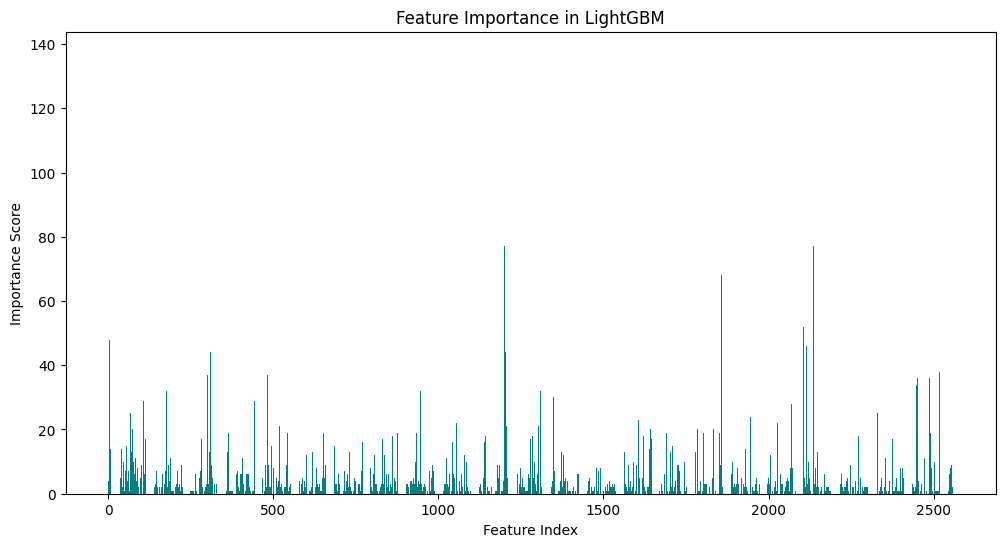

In [ ]:
import os
import cv2
import numpy as np
import glob
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tqdm import tqdm  # For progress tracking

# ✅ Load Pretrained EfficientNet-B7
base_model = EfficientNetB7(weights="imagenet", include_top=False)
model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# ✅ Define dataset path and categories
dataset_path = "/content/drive/MyDrive/Dataset-Lungcancer/The IQ-OTHNCCD lung cancer dataset"
categories = ["Bengin cases", "Malignant cases", "Normal cases"]
img_size = 600  # EfficientNetB7 input size

# ✅ Initialize storage for features and labels
features = []
labels = []

# ✅ Function to preprocess images
def preprocess_image(image_path):
    img = cv2.imread(image_path)  # Load image
    if img is None:
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (img_size, img_size))  # Resize to 600x600 (EfficientNet-B7 input size)
    img = preprocess_input(img)  # Normalize using EfficientNet preprocessing
    return img

# ✅ Extract features for each category
for label, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    image_files = glob.glob(os.path.join(category_path, "*.*"))  # Supports .png, .jpg, etc.

    print(f"Processing {len(image_files)} images from {category}...")

    for image_path in tqdm(image_files):
        img = preprocess_image(image_path)
        if img is not None:
            img = np.expand_dims(img, axis=0)  # Add batch dimension
            feature_vector = model.predict(img)  # Extract features
            features.append(feature_vector.flatten())  # Store flattened feature vector
            labels.append(label)  # Store corresponding label

# ✅ Convert lists to NumPy arrays
features = np.array(features)
labels = np.array(labels)

print("Feature extraction completed!")
print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")

plt.figure(figsize=(12, 6))
importances = lgb_model.feature_importances_
plt.bar(range(len(importances)), importances, color="teal")
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.title("Feature Importance in LightGBM")
plt.show()

# # ✅ Save extracted features for later use
np.save("/content/drive/MyDrive/Processed_Lung_Cancer_Data/EfficientNetB7_features.npy", features)
np.save("/content/drive/MyDrive/Processed_Lung_Cancer_Data/EfficientNetB7_labels.npy", labels)
np.save("/content/drive/MyDrive/Processed_Lung_Cancer_Data/lung_cancer_labels.npy", labels)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# ✅ Load extracted features and labels
features = np.load("/content/drive/MyDrive/Processed_Lung_Cancer_Data/EfficientNetB7_features.npy")
labels = np.load("/content/drive/MyDrive/Processed_Lung_Cancer_Data/EfficientNetB7_labels.npy")

# ✅ Split into train & test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# ✅ Train a Random Forest classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# ✅ Predict on test set
y_pred = classifier.predict(X_test)

# ✅ Compute Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Feature Extraction Accuracy using EfficientNetB7: {accuracy * 100:.2f}%")

# ✅ Detailed Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Bengin cases", "Malignant cases", "Normal cases"]))

Feature Extraction Accuracy using EfficientNetB7: 89.09%
Classification Report:
                 precision    recall  f1-score   support

   Bengin cases       1.00      0.24      0.39        29
Malignant cases       0.97      1.00      0.99       109
   Normal cases       0.79      0.98      0.87        82

       accuracy                           0.89       220
      macro avg       0.92      0.74      0.75       220
   weighted avg       0.91      0.89      0.87       220



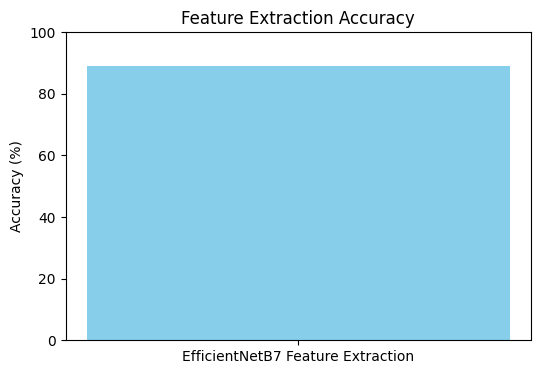

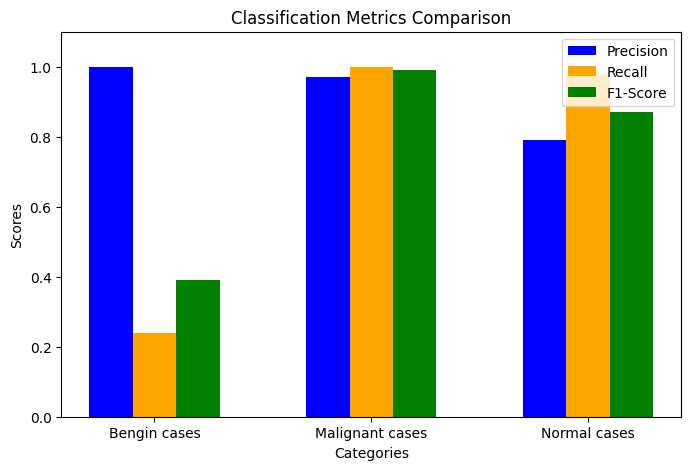

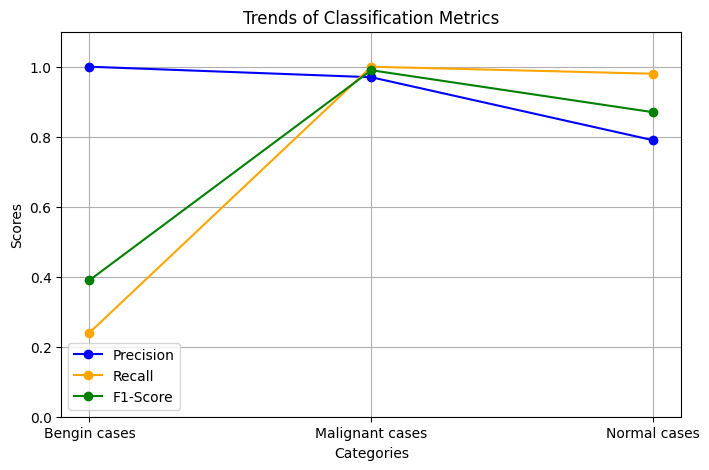

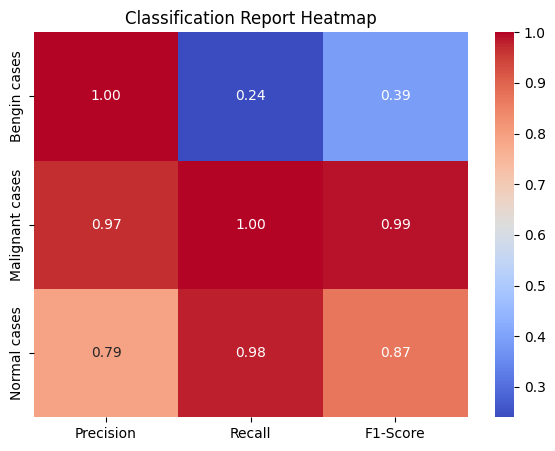

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
categories = ["Bengin cases", "Malignant cases", "Normal cases"]
precision = [1.00, 0.97, 0.79]
recall = [0.24, 1.00, 0.98]
f1_score = [0.39, 0.99, 0.87]
accuracy = 89.09  # Feature Extraction Accuracy

# -------- Plot 1: Accuracy Bar Chart --------
plt.figure(figsize=(6, 4))
plt.bar(['EfficientNetB7 Feature Extraction'], [accuracy], color='skyblue')
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Feature Extraction Accuracy')
plt.show()

# -------- Plot 2: Grouped Bar Chart for Precision, Recall, F1-score --------
x = np.arange(len(categories))  # Label locations
width = 0.2  # Bar width

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width, precision, width, label='Precision', color='blue')
ax.bar(x, recall, width, label='Recall', color='orange')
ax.bar(x + width, f1_score, width, label='F1-Score', color='green')

ax.set_xlabel('Categories')
ax.set_ylabel('Scores')
ax.set_title('Classification Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
plt.ylim(0, 1.1)
plt.show()

# -------- Plot 3: Line Chart for Trends --------
plt.figure(figsize=(8, 5))
plt.plot(categories, precision, marker='o', linestyle='-', label='Precision', color='blue')
plt.plot(categories, recall, marker='o', linestyle='-', label='Recall', color='orange')
plt.plot(categories, f1_score, marker='o', linestyle='-', label='F1-Score', color='green')

plt.xlabel('Categories')
plt.ylabel('Scores')
plt.title('Trends of Classification Metrics')
plt.legend()
plt.ylim(0, 1.1)
plt.grid(True)
plt.show()

# -------- Plot 4: Heatmap of Classification Report --------
df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_score
}, index=categories)

plt.figure(figsize=(7, 5))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Classification Report Heatmap")
plt.show()


#  Dataset training - LightGBM

Original Labels Shape: (1097,)
Reshaped Labels Shape: (1097,)
Unique Labels: [0 1 2]
Label Counts: [120 561 416]
Train set size: 877, Test set size: 220
Train labels size: 877, Test labels size: 220
🚀 Training LightGBM Model...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 652739
[LightGBM] [Info] Number of data points in the train set: 877, number of used features: 2560
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Training Accuracy: 1.0000
✅ Testing Accuracy: 0.9500
✅ Model saved at /content/drive/MyDrive/Processed_Lung_Cancer_Data/Lung_Cancer_LGBM_Model.pkl!


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


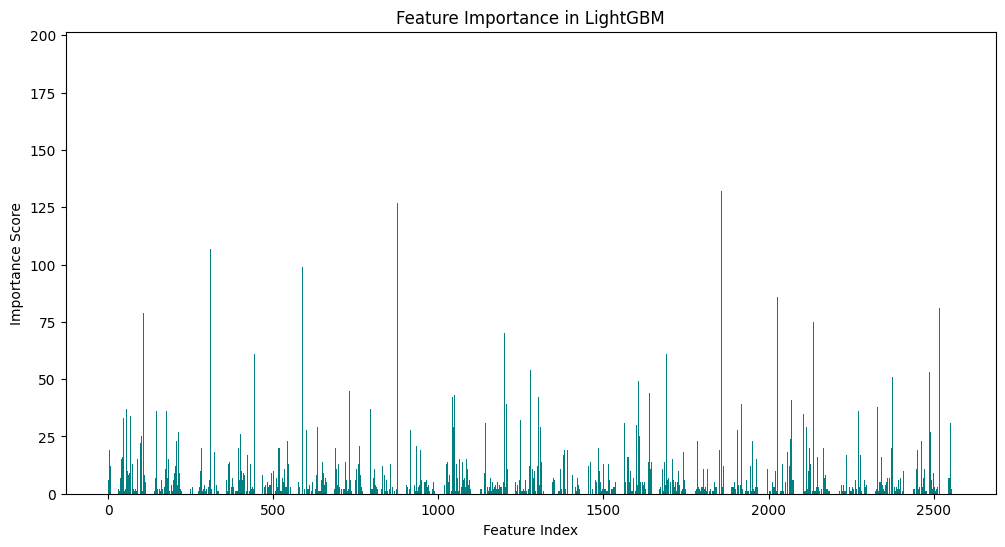

In [ ]:
import os
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ✅ Define paths for extracted features & labels
feature_data_path = "/content/drive/MyDrive/Processed_Lung_Cancer_Data/EfficientNetB7_features.npy"
label_data_path = "/content/drive/MyDrive/Processed_Lung_Cancer_Data/lung_cancer_labels.npy"

# ✅ Check if dataset files exist
if not os.path.exists(feature_data_path) or not os.path.exists(label_data_path):
    raise FileNotFoundError("Feature or Label file is missing! Please run feature extraction first.")

# ✅ Load extracted features & labels
features = np.load(feature_data_path)
labels = np.load(label_data_path)

# ✅ Ensure Labels are 1D
print(f"Original Labels Shape: {labels.shape}")
labels = labels.reshape(-1)  # Flatten to 1D if needed
print(f"Reshaped Labels Shape: {labels.shape}")

# ✅ Print unique labels to check for class imbalance
unique_labels, label_counts = np.unique(labels, return_counts=True)
print(f"Unique Labels: {unique_labels}")
print(f"Label Counts: {label_counts}")

# ✅ Split dataset into Train & Test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

# ✅ Check dataset sizes after splitting
print(f"Train set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")
print(f"Train labels size: {y_train.shape[0]}, Test labels size: {y_test.shape[0]}")

# ✅ Train LightGBM Classifier with Optimized Parameters
lgb_model = lgb.LGBMClassifier(
    boosting_type="gbdt",
    objective="multiclass",
    num_class=len(np.unique(labels)),  # Auto-detect number of classes
    metric="multi_logloss",
    num_leaves=128,
    learning_rate=0.02,
    n_estimators=500,
    max_depth=12,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_alpha=0.1,
    reg_lambda=0.2,
    class_weight="balanced",  # ⚠️ Helps with class imbalance
    random_state=42
)

# ✅ Train Model
print("🚀 Training LightGBM Model...")
lgb_model.fit(X_train, y_train)

# ✅ Make Predictions
y_train_pred = lgb_model.predict(X_train)
y_test_pred = lgb_model.predict(X_test)

# ✅ Ensure Predictions Shape Matches Test Labels
assert y_test_pred.shape[0] == y_test.shape[0], f"Mismatch in predictions: y_test={y_test.shape[0]}, y_test_pred={y_test_pred.shape[0]}"

# ✅ Evaluate Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"✅ Training Accuracy: {train_accuracy:.4f}")
print(f"✅ Testing Accuracy: {test_accuracy:.4f}")

# ✅ Save the Trained Model
model_path = "/content/drive/MyDrive/Processed_Lung_Cancer_Data/Lung_Cancer_LGBM_Model.pkl"
joblib.dump(lgb_model, model_path)
print(f"✅ Model saved at {model_path}!")

# ✅ Load the model later for predictions
loaded_model = joblib.load(model_path)
y_pred = loaded_model.predict(X_test)

# ✅ Feature Importance Visualization
plt.figure(figsize=(12, 6))
importances = lgb_model.feature_importances_
plt.bar(range(len(importances)), importances, color="teal")
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.title("Feature Importance in LightGBM")
plt.show()


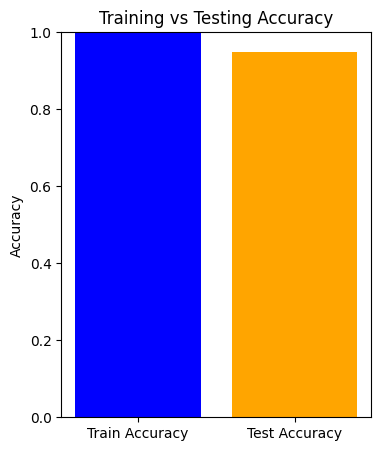

In [ ]:
# 🎨 **Plot Accuracy Comparison**
plt.figure(figsize=(4, 5))
plt.bar(["Train Accuracy", "Test Accuracy"], [train_accuracy, test_accuracy], color=["blue", "orange"])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Training vs Testing Accuracy")
plt.show()

In [ ]:
import os

feature_data_path = "/content/drive/MyDrive/Processed_Lung_Cancer_Data/EfficientNetB7_features.npy"
label_data_path = "/content/drive/MyDrive/Processed_Lung_Cancer_Data/EfficientNetB7_labels.npy"

print("Feature File Exists:", os.path.exists(feature_data_path))
print("Label File Exists:", os.path.exists(label_data_path))


Feature File Exists: True
Label File Exists: True


# Model Evaluation & Accuracy Metrics

In [ ]:
import os
import cv2
import numpy as np
import joblib
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load trained model
lgb_model = joblib.load("/content/drive/MyDrive/Lung_Cancer_LGBM_Model.pkl")

# Load EfficientNet-B7 for feature extraction
base_model = EfficientNetB7(weights="imagenet", include_top=False)
feature_extractor = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Categories
categories = ["Benign", "Malignant", "Normal"]
img_size = 600  # EfficientNetB7 input size

def extract_features(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)

    # Extract feature vector
    feature_vector = feature_extractor.predict(img)
    return feature_vector.flatten()

def predict_lung_cancer_from_folder(folder_path):
    if not os.path.exists(folder_path):
        print("❌ Error: Folder not found!")
        return

    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        if os.path.isfile(image_path):
            features = extract_features(image_path)
            if features is None:
                print(f"❌ Error: Unable to process {filename}")
                continue

            prediction = lgb_model.predict([features])[0]
            predicted_label = categories[prediction]

            print(f"🔹 Image: {filename} | Prediction: {predicted_label}")

# ✅ Test with a folder containing images
test_folder = "/content/drive/MyDrive/Test Case"
predict_lung_cancer_from_folder(test_folder)


1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
🔹 Image: Testcase1.jpg | Prediction: Malignant


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ✅ Predict test set
y_pred = lgb_model.predict(X_test)

# ✅ Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🔹 LightGBM Model Accuracy: {accuracy * 100:.2f}%")

# ✅ Classification Report
print("\n🔹 Classification Report:")
print(classification_report(y_test, y_pred, target_names=categories))

# ✅ Confusion Matrix
print("\n🔹 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



🔹 LightGBM Model Accuracy: 99.09%

🔹 Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.96      0.96        24
   Malignant       1.00      1.00      1.00       113
      Normal       0.99      0.99      0.99        83

    accuracy                           0.99       220
   macro avg       0.98      0.98      0.98       220
weighted avg       0.99      0.99      0.99       220


🔹 Confusion Matrix:
[[ 23   0   1]
 [  0 113   0]
 [  1   0  82]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# Highlight Cancer-Affected Regions (Grad-CAM)

✅ Loaded Model from /content/drive/MyDrive/Processed_Lung_Cancer_Data/Lung_Cancer_LGBM_Model.pkl
✅ EfficientNetB7 Loaded Successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_4890']
Received: inputs=Tensor(shape=(1, 600, 600, 3))
  warnings.warn(msg)


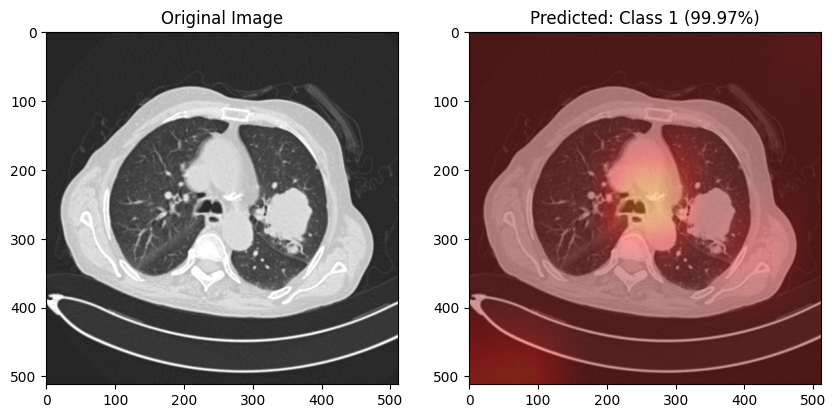

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow.keras.backend as K
import joblib

# ✅ Load the Pre-trained LightGBM Model
lgb_model_path = "/content/drive/MyDrive/Processed_Lung_Cancer_Data/Lung_Cancer_LGBM_Model.pkl"
lgb_model = joblib.load(lgb_model_path)
print(f"✅ Loaded Model from {lgb_model_path}")

# ✅ Load Pre-trained EfficientNetB7 for Feature Extraction
base_model = EfficientNetB7(weights="imagenet", include_top=False, input_shape=(600, 600, 3))
feature_extractor = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))
print("✅ EfficientNetB7 Loaded Successfully!")

# ✅ Grad-CAM Function (Improved)
def grad_cam(image_path):
    # ✅ Load & Preprocess Image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (600, 600))  # EfficientNetB7 requires 600x600
    img = preprocess_input(img)
    img_tensor = np.expand_dims(img, axis=0)

    # ✅ Convert to TensorFlow tensor
    img_tensor = tf.convert_to_tensor(img_tensor, dtype=tf.float32)

    # ✅ Feature Extraction for LightGBM
    extracted_features = feature_extractor.predict(img_tensor).flatten().reshape(1, -1)

    # ✅ Check Model Feature Dimension
    if extracted_features.shape[1] != lgb_model.booster_.num_feature():
        raise ValueError(
            f"Feature mismatch: Model expects {lgb_model.booster_.num_feature()} features, but got {extracted_features.shape[1]}"
        )

    # ✅ Make Prediction using LightGBM
    prediction_probabilities = lgb_model.predict_proba(extracted_features)[0]
    predicted_class = np.argmax(prediction_probabilities)
    confidence = prediction_probabilities[predicted_class] * 100  # Convert to percentage

    # ✅ Grad-CAM Implementation
    last_conv_layer = base_model.get_layer("block7a_project_conv")  # More relevant for lung region
    grad_model = Model([base_model.input], [last_conv_layer.output, base_model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        class_score = predictions[:, predicted_class]  # Focus on predicted class activation

    grads = tape.gradient(class_score, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = np.mean(conv_outputs[0] * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # Ensure only positive activations
    heatmap /= np.max(heatmap)  # Normalize

    # ✅ Smooth Heatmap using Gaussian Blur
    heatmap = cv2.GaussianBlur(heatmap, (5, 5), sigmaX=2)

    # ✅ Overlay Heatmap on Original Image
    original_img = cv2.imread(image_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)

    # ✅ Display Results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title(f"Predicted: Class {predicted_class} ({confidence:.2f}%)")

    plt.show()

# ✅ Test on a Sample Image
test_image_path = "/content/drive/MyDrive/Test Case/Testcase1.jpg"
grad_cam(test_image_path)


# Performance Analysis

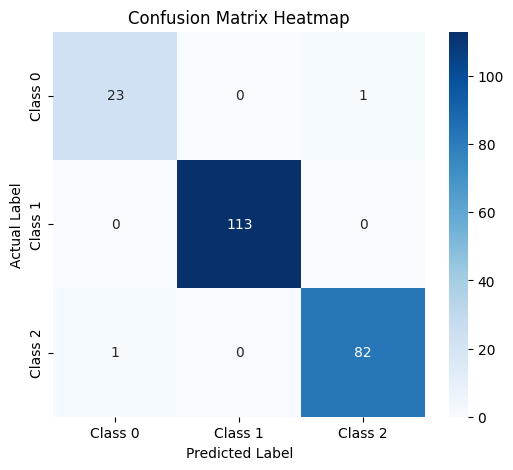

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

# Given Confusion Matrix
cm = np.array([[23, 0, 1],
               [0, 113, 0],
               [1, 0, 82]])

# Class labels
classes = ['Class 0', 'Class 1', 'Class 2']

# 1️⃣ Confusion Matrix Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix Heatmap")
plt.show()


In [ ]:
# 2️⃣ Classification Report
y_true = np.array([0]*24 + [1]*113 + [2]*83)  # Ground Truth
y_pred = np.array([0]*23 + [2] + [1]*113 + [2]*82 + [0])  # Predicted

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))




Classification Report:

              precision    recall  f1-score   support

     Class 0       0.96      0.96      0.96        24
     Class 1       1.00      1.00      1.00       113
     Class 2       0.99      0.99      0.99        83

    accuracy                           0.99       220
   macro avg       0.98      0.98      0.98       220
weighted avg       0.99      0.99      0.99       220



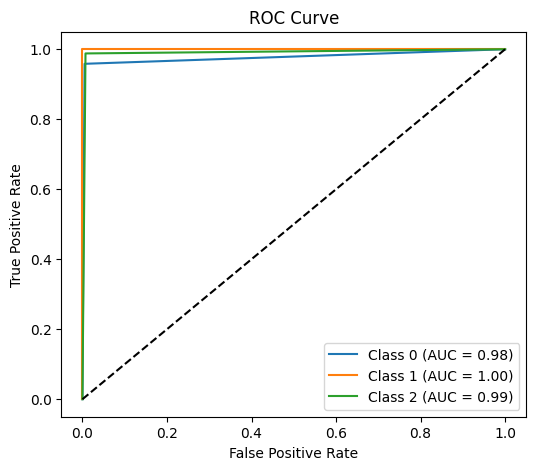

In [ ]:
# 3️⃣ ROC Curve (One-vs-All Approach for Multi-Class)
plt.figure(figsize=(6,5))
for i in range(3):
    y_true_binary = (y_true == i).astype(int)
    y_score = (y_pred == i).astype(int)

    fpr, tpr, _ = roc_curve(y_true_binary, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()



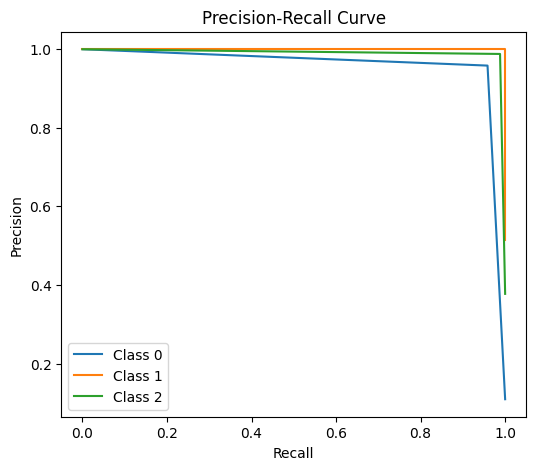

In [ ]:
# 4️⃣ Precision-Recall Curve
plt.figure(figsize=(6,5))
for i in range(3):
    y_true_binary = (y_true == i).astype(int)
    y_score = (y_pred == i).astype(int)

    precision, recall, _ = precision_recall_curve(y_true_binary, y_score)
    plt.plot(recall, precision, label=f"Class {i}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

Log Loss & ROC Curve data

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-48-4ff9711156b3>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Log Loss"], y=[logloss], palette="coolwarm", width=0.4)
<ipython-input-48-4ff9711156b3>:50: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-4ff9711156b3>:50: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-pac

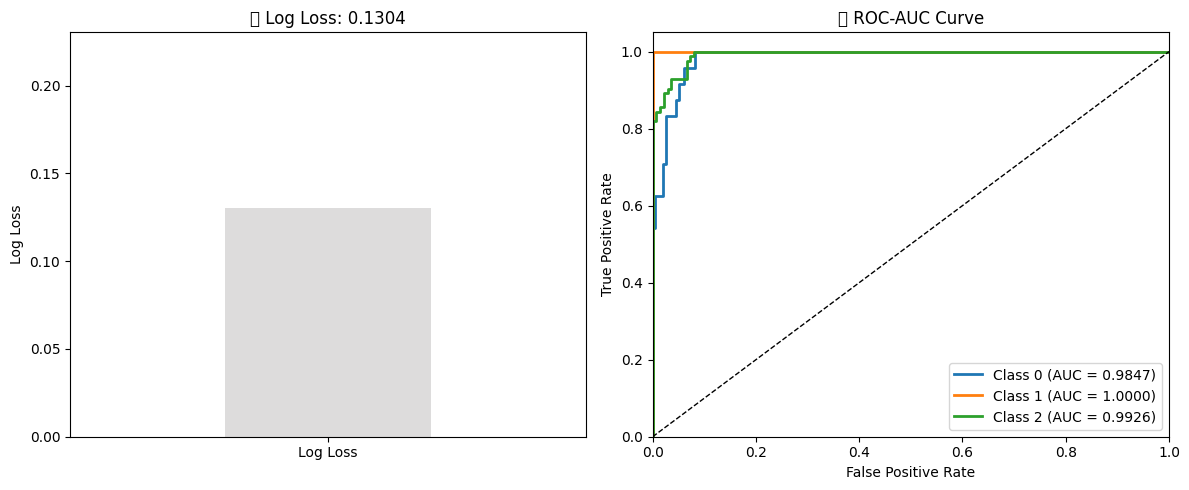

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, log_loss

# Compute Log Loss
logloss = log_loss(y_test, lgb_model.predict_proba(X_test))

# Compute ROC Curve and AUC
y_probs = lgb_model.predict_proba(X_test)
if y_probs.shape[1] == 2:  # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_probs[:, 1])
    roc_auc = auc(fpr, tpr)
else:  # Multi-class classification (One-vs-Rest)
    from sklearn.preprocessing import label_binarize
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(y_probs.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

# Create figure
plt.figure(figsize=(12, 5))

# Plot Log Loss as a single bar
plt.subplot(1, 2, 1)
sns.barplot(x=["Log Loss"], y=[logloss], palette="coolwarm", width=0.4)
plt.ylabel("Log Loss")
plt.ylim(0, logloss + 0.1)  # Ensures the bar is visible
plt.title(f"📉 Log Loss: {logloss:.4f}")

# Plot ROC Curve
plt.subplot(1, 2, 2)
if y_probs.shape[1] == 2:  # Binary classification
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
else:  # Multi-class classification
    for i in range(y_probs.shape[1]):
        plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {i} (AUC = {roc_auc[i]:.4f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📊 ROC-AUC Curve")
plt.legend(loc="lower right")

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(lgb_model, X_train, y_train, cv=5, scoring="accuracy")
print(f"Cross-Validation Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Cross-Validation Std Dev: {cv_scores.std():.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 599287
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 2560
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 599314
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 2560
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 600198
[LightGBM] [Info] Number of data points in the train set: 702, number of used features: 2560
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 600164
[LightGBM] [Info] Number of data points in the train set: 702, number of used features: 2560
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 600164
[LightGBM] [Info] Number of data points in the train set: 702, number of used features: 2560
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
pip install opencv-python numpy matplotlib

# Confusion Matrix

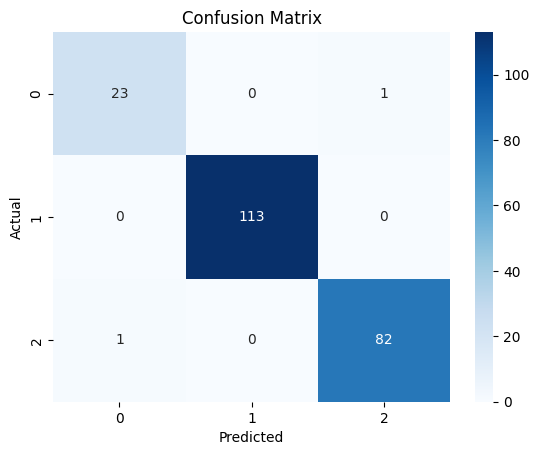

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Normalized Confusion Matrix

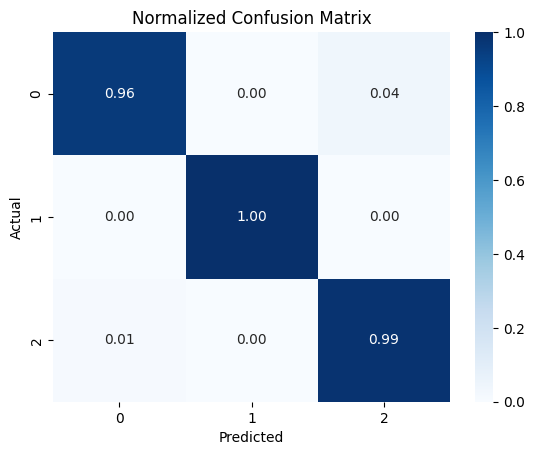

In [ ]:
cm_norm = confusion_matrix(y_true, y_pred, normalize='true')
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix")
plt.show()

Confusion Matrix with Classification Report

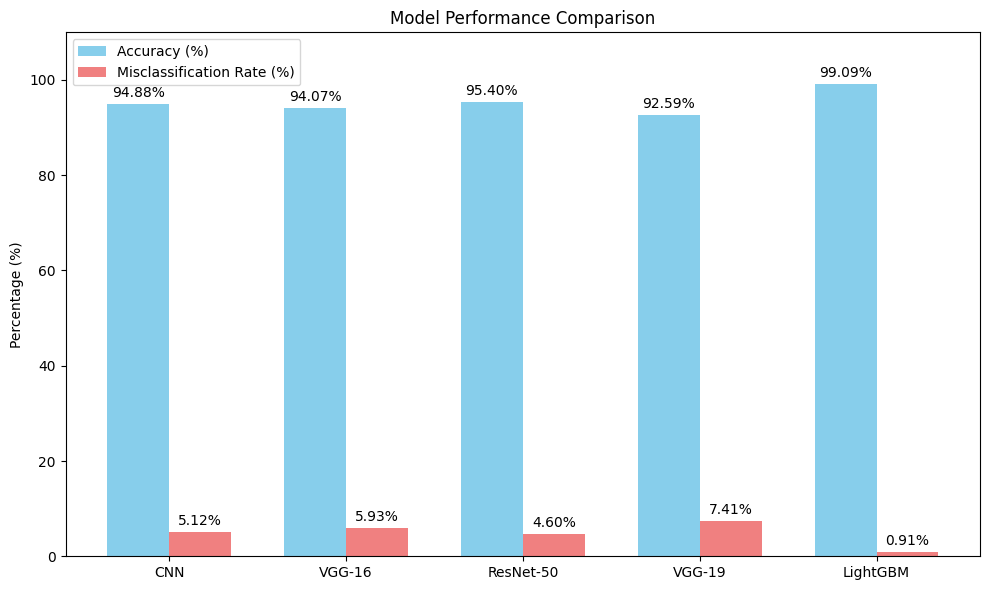

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names and their accuracies
models = ['CNN', 'VGG-16', 'ResNet-50', 'VGG-19', 'LightGBM']
accuracies = [94.88, 94.07, 95.40, 92.59, 99.09]
misclass_rates = [100 - acc for acc in accuracies]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Accuracy bars
acc_bars = ax.bar(x - width/2, accuracies, width, label='Accuracy (%)', color='skyblue')
# Misclassification bars
misclass_bars = ax.bar(x + width/2, misclass_rates, width, label='Misclassification Rate (%)', color='lightcoral')

# Label formatting
ax.set_ylabel('Percentage (%)')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 110)
ax.legend()

# Add value labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(acc_bars)
add_labels(misclass_bars)

plt.tight_layout()
plt.show()
